In [217]:
import warnings
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker

from scipy import stats
from pylab import rcParams
from matplotlib.pyplot import MultipleLocator

rcParams['figure.figsize']	=	(20,8)

sns.set_style('darkgrid')

plt.style.use('seaborn-darkgrid')

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from io import StringIO

from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.datasets import make_hastie_10_2

from sklearn import svm
from sklearn.linear_model import SGDClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from patsy import dmatrices
from sklearn import metrics


from sklearn.metrics import plot_confusion_matrix,make_scorer,precision_recall_curve
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,f1_score,auc,confusion_matrix,classification_report

from sklearn import tree
from sklearn import preprocessing
from sklearn import ensemble


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pydotplus

from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold


import time
from sklearn.metrics import roc_auc_score
from matplotlib.colors import ListedColormap
from sklearn import neighbors,datasets
import graphviz
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,	Ridge,	RidgeClassifier

import itertools

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [145]:
#	Read	data	from	Google	Sheet
telco_df=pd.read_csv('archive/Telco-Customer-Churn.csv')

telco_df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [9]:
list(telco_df)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [10]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [147]:
# check for duplicate customers
dups = telco_df[telco_df.duplicated(subset=['customerID'])==True]
print(f'{dups.shape[0]} duplicate CustomerIDs found')

0 duplicate CustomerIDs found


In [11]:
telco_df.shape

(7043, 21)

In [4]:
#	Counts	all	missing	values	and	its	percentage.
total	=	telco_df.isnull().sum().sort_values(ascending	=	False)
frames	=	[total]
#	pd.concat():	axis=0	means	index,	axis=1	means	column,	keys	=	name	of	the	column.
missing_data	=	pd.concat(frames,	axis	=	1,	keys	=	['Total'])
missing_data.head()

,Total
Churn,0
OnlineSecurity,0
gender,0
SeniorCitizen,0
Partner,0


In [3]:
telco_df['TotalCharges']	=	telco_df["TotalCharges"].replace(" ",0).astype('float32')
telco_df.TotalCharges.fillna(value	=	telco_df.tenure *telco_df.MonthlyCharges,	inplace	=	True)

In [5]:
#	Check	of	outliers	by	applying	the	IQR	method	checking	if	values	are	way	outside	the	IQR	borders.
numerical_features	=	["tenure",	"MonthlyCharges",	"TotalCharges"]
df_num	=	telco_df[numerical_features]
df_num.describe()
Q1	=	df_num.quantile(0.25)
Q3	=	df_num.quantile(0.75)
IQR	=	Q3 - Q1
IQR
((df_num <	(Q1 - 1.5 * IQR))	|	(df_num >	(Q3 + 1.5 * IQR))).any()


tenure            False
MonthlyCharges    False
TotalCharges      False
dtype: bool

In [17]:
#	Create	a	function	to	generate	boxplots.
plots	=	{1	:	[111],	2:	[121,	122],	3:	[131,	132,	133],	4:	[221,	222,	223,	224],	5:	[231,	232,	233,	234,
235],	6:	[231,	232,	233,	234,	235,	236]}
def boxplot(x,	y,	df):
				
				rows	=	int(str(plots[len(y)][0])[0])
				columns	=	int(str(plots[len(y)][0])[1])
				plt.figure(figsize=(7*columns,	7*rows))
				
				for i,	j in enumerate(y):
								plt.subplot(plots[len(y)][i])
								ax	=	sns.boxplot(x=x,	y=j,	data=df[[x,	j]],	palette="Blues",	linewidth=1)
								ax.set_title(j)
								#	Set	y	tick
								fmt	=	'{x:,.0f}'
								tick	=	ticker.StrMethodFormatter(fmt)
								ax.yaxis.set_major_formatter(tick)
								
				return plt.show()


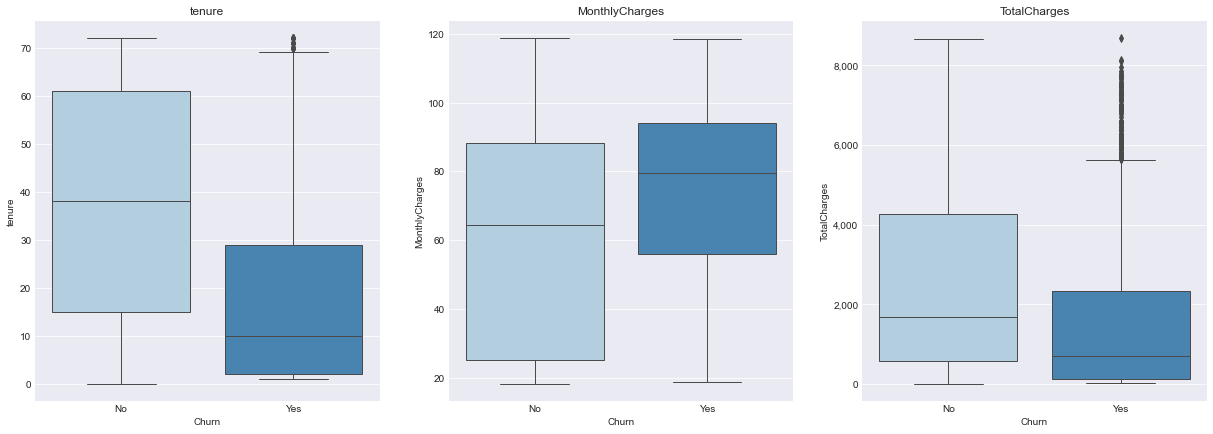

In [18]:
#	Generate	boxplots	for	tenure,	MonthlyCharges	and	TotalCharges.
rcParams['figure.figsize']	=	(20,	8)
boxplot("Churn",	["tenure",	"MonthlyCharges",	"TotalCharges"],	telco_df)


In [19]:
#	Create	a	function	to	generate	countplots:
def countplot(x,	y,	df):
				
				rows	=	int(str(plots[len(y)][0])[0])
				columns	=	int(str(plots[len(y)][0])[1])
				
				plt.figure(figsize=(7*columns,	7*rows))
				
				for i,	j in enumerate(y):
								plt.subplot(plots[len(y)][i])
								ax	=	sns.countplot(x	=	j,	hue	=	x,	data	=	df,	palette	=	'Set2',	alpha	=	0.8,	linewidth	=	0.4,
edgecolor	=	'black')
								ax.set_title(j)
								
				return plt.show()

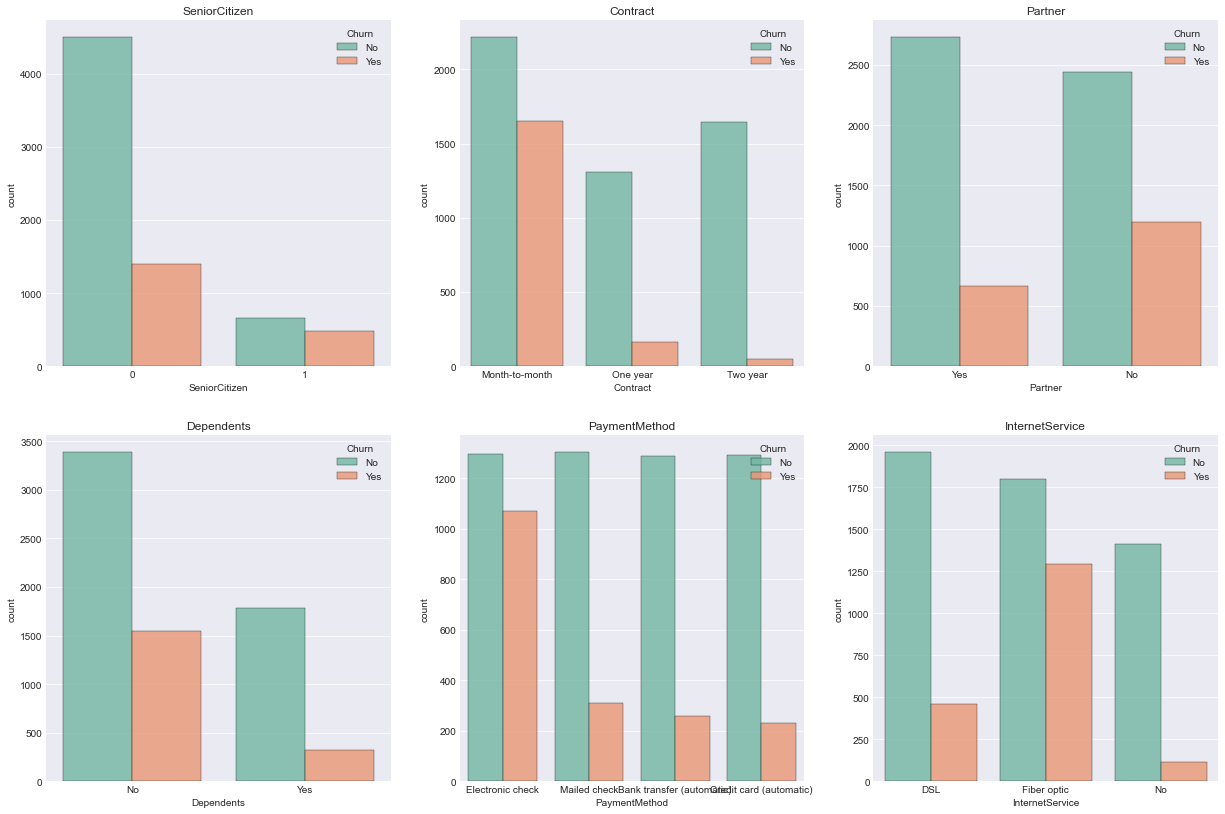

In [20]:
rcParams['figure.figsize']	=	(20,	8)
#	Generate	countplots	for	various	features.
countplot("Churn",	['SeniorCitizen',	'Contract',	'Partner',	'Dependents',	'PaymentMethod',
'InternetService'],	telco_df)

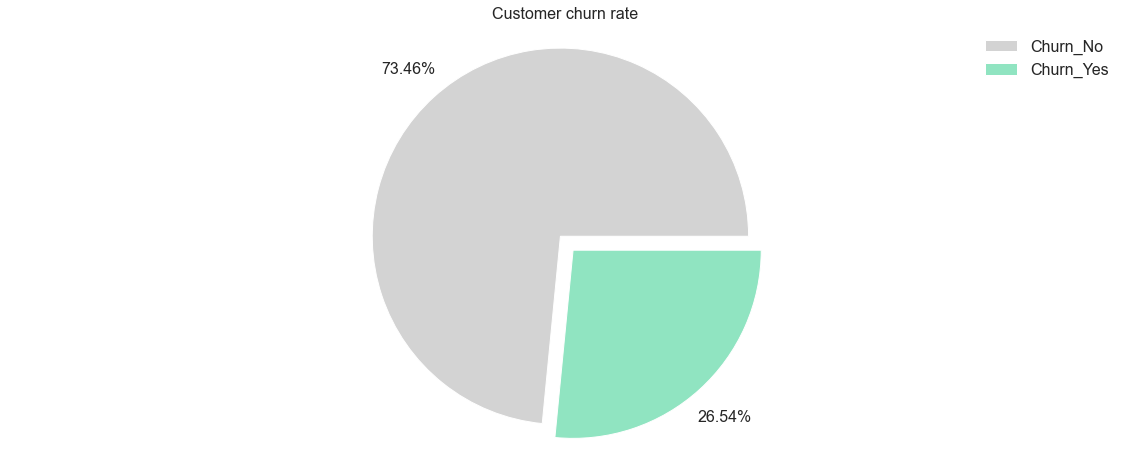

In [23]:
rcParams['figure.figsize']	=	(20,	8)
#	Count	unique	values	in	'Churn'.
count	=	telco_df['Churn']
#	Compute	the	percentage	of	unique	values	in	'Churn'.
percent	=	(telco_df['Churn'].value_counts()	/ telco_df['Churn'].count()	*100).round(2)
#	Create	a	summary	dataframe
frames	=	[count,	percent]
churn_agg	=	pd.concat(frames,	axis=1,	keys	=	['Count',	'Percent'])
churn_agg
fig,	ax	=	plt.subplots()
#	set	font	size.
plt.rcParams['font.size']=16
#	set	color	palette.

color_palette_list	=	['lightgrey',	'#90e4c1']
#	make	a	pie	chart.
percentages	=	percent.values.tolist()
explode=(0.1,	0)
labels	=	['Churn_No',	'Churn_Yes']
ax.pie(percentages,	colors	=	color_palette_list[0:2],	autopct	=	'%1.2f%%',	explode=explode,	shadow	=	False,
startangle	=	0,	pctdistance	=	1.2,	labeldistance	=	1.4)
ax.axis('equal')
ax.set_title('Customer churn rate',	fontsize	=	16)
ax.legend(labels)

In [24]:
cat_telco	=	telco_df.select_dtypes(include	=	'object').copy()
cat_telco	=	cat_telco.drop(columns='customerID')
cat_telco.head(2)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No


In [25]:
cat_telco.describe(include	=	'object')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


<ipython-input-26-a0395595ef39>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y)	for y in ax.get_yticks()])
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


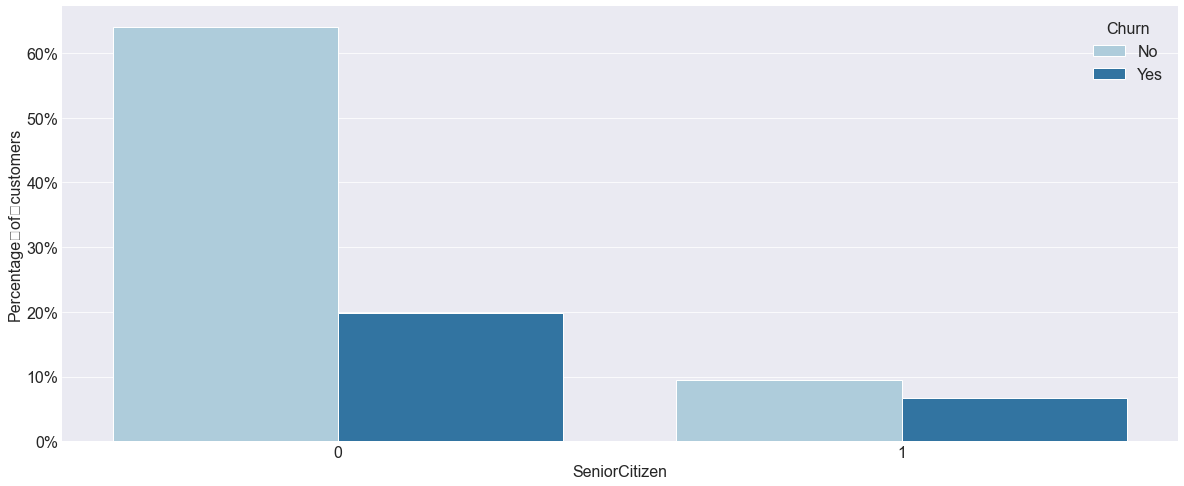

In [26]:
def barplot_percentages(feature,	orient='v',	axis_name="Percentage	of	customers"):
				ratios	=	pd.DataFrame()
				g	=	telco_df.groupby(feature)["Churn"].value_counts().to_frame()
				g	=	g.rename({"Churn":	axis_name},	axis=1).reset_index()
				g[axis_name]	=	g[axis_name]/len(telco_df)
				if orient	==	'v':
								ax	=	sns.barplot(x=feature,	y=	axis_name,	hue='Churn',	data=g,	orient=orient,	palette	=
sns.color_palette('Paired'))
								ax.set_yticklabels(['{:,.0%}'.format(y)	for y in ax.get_yticks()])
				else:
								ax	=	sns.barplot(x=	axis_name,	y=feature,	hue='Churn',	data=g,	orient=orient,	palette	=
sns.color_palette('Paired'))
								ax.set_xticklabels(['{:,.0%}'.format(x)	for x in ax.get_xticks()])
				ax.plot()
barplot_percentages("SeniorCitizen")

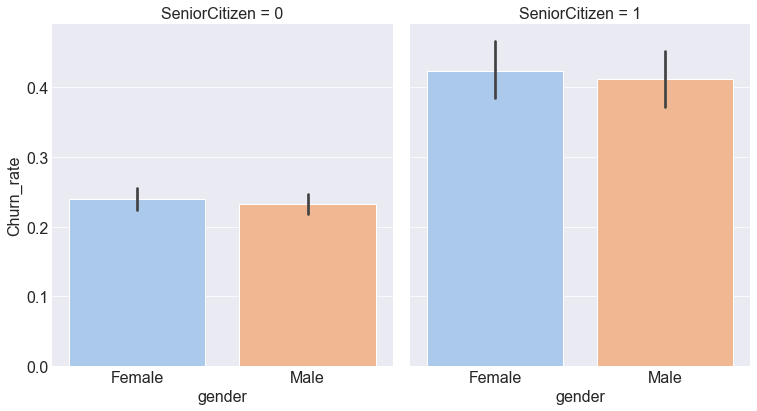

In [27]:
telco_df['Churn_rate']	=	telco_df['Churn'].replace("No",	0).replace("Yes",	1)
g	=	sns.FacetGrid(telco_df,	col	=	"SeniorCitizen",	height	=	6,	aspect	=	.9)
ax	=	g.map(sns.barplot,	"gender",	"Churn_rate",	palette	=	"pastel",	order=	['Female',	'Male'])

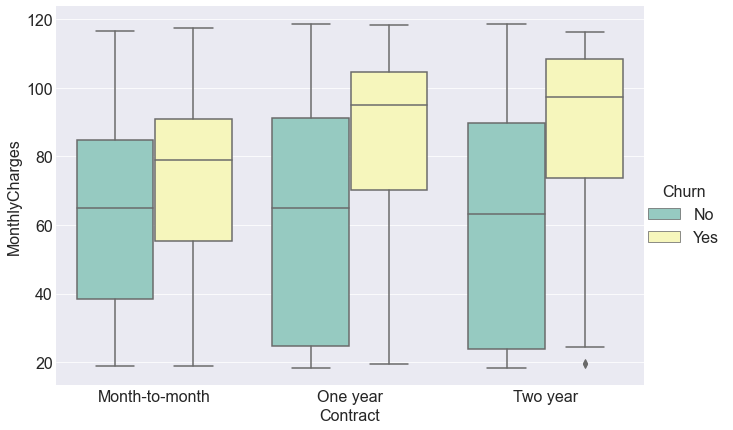

In [28]:
ax	=	sns.catplot(x="Contract",	y="MonthlyCharges",	hue="Churn",	kind="box",	data=telco_df,	height	=	6,
aspect=1.5,	palette	=	"Set3")

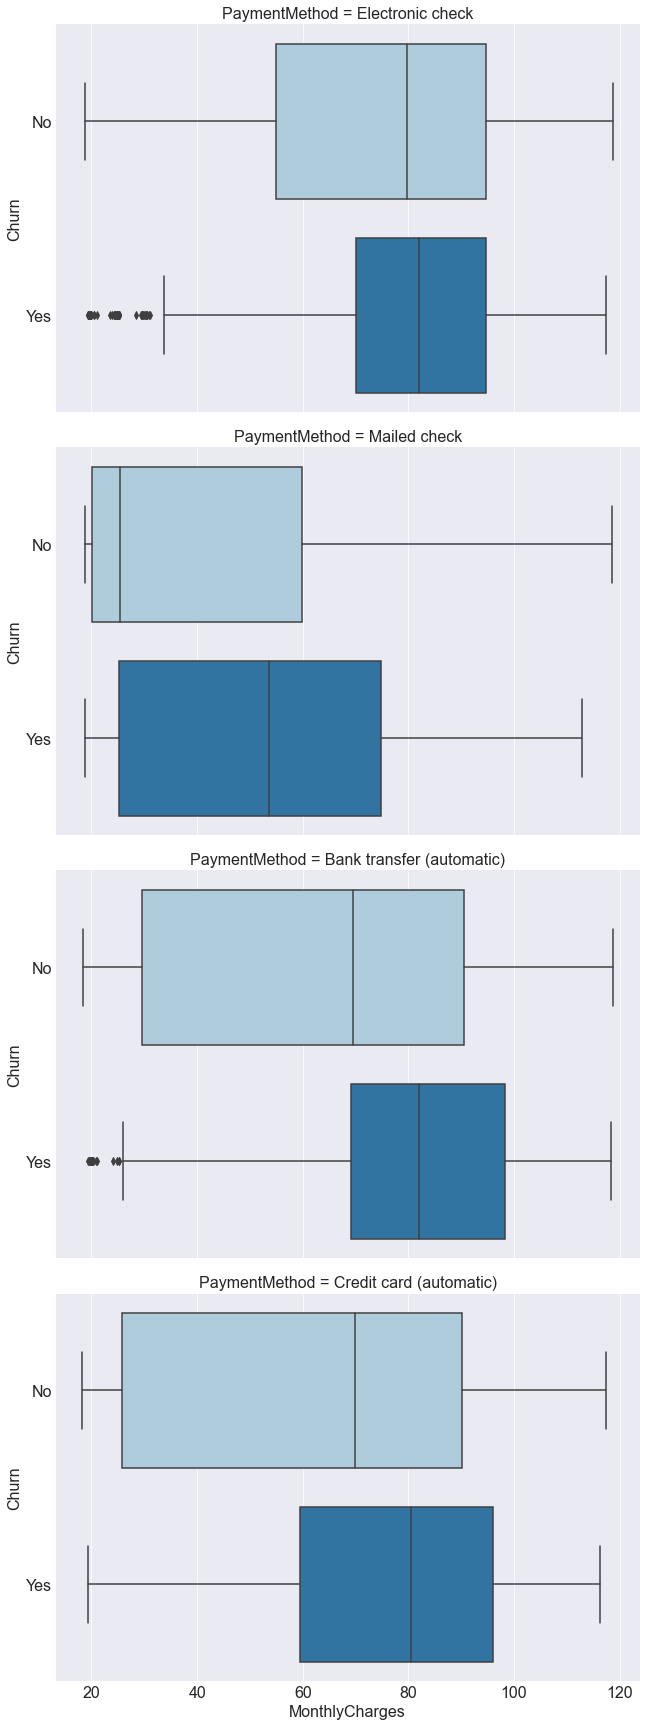

In [29]:
ax	=	sns.catplot(y	=	"Churn",	x	=	"MonthlyCharges",	row	=	"PaymentMethod",	kind	=	"box",	data=telco_df,
height=6,	aspect=1.5,	orient='h',	palette	=	"Paired")

In [30]:
telco_df.describe().round()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_rate
count,7043.0,7043.0,7043.0,7043.0,7043.0
mean,0.0,32.0,65.0,2280.0,0.0
std,0.0,25.0,30.0,2267.0,0.0
min,0.0,0.0,18.0,0.0,0.0
25%,0.0,9.0,36.0,399.0,0.0
50%,0.0,29.0,70.0,1395.0,0.0
75%,0.0,55.0,90.0,3787.0,1.0
max,1.0,72.0,119.0,8685.0,1.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


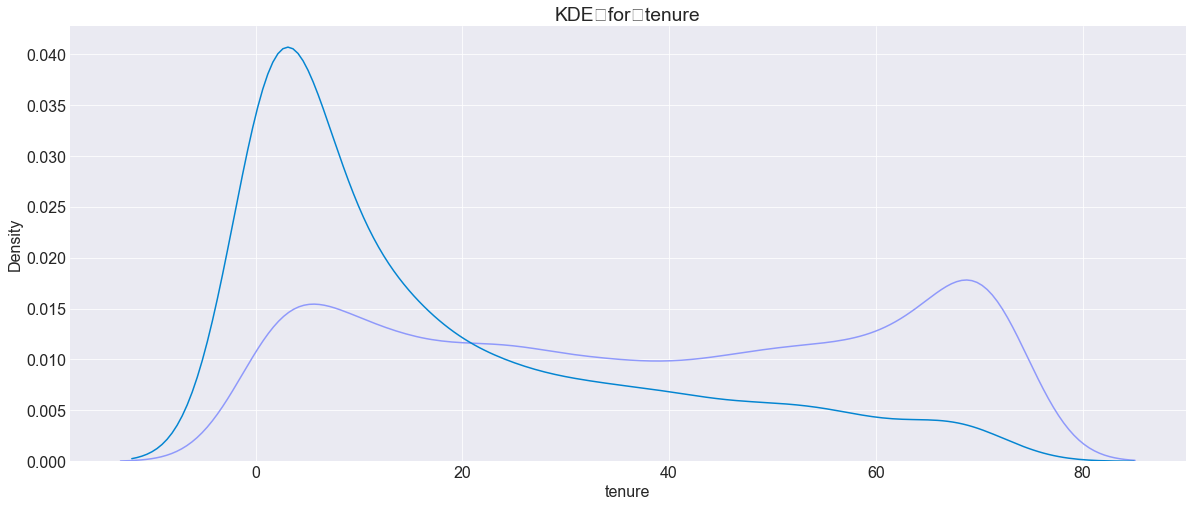

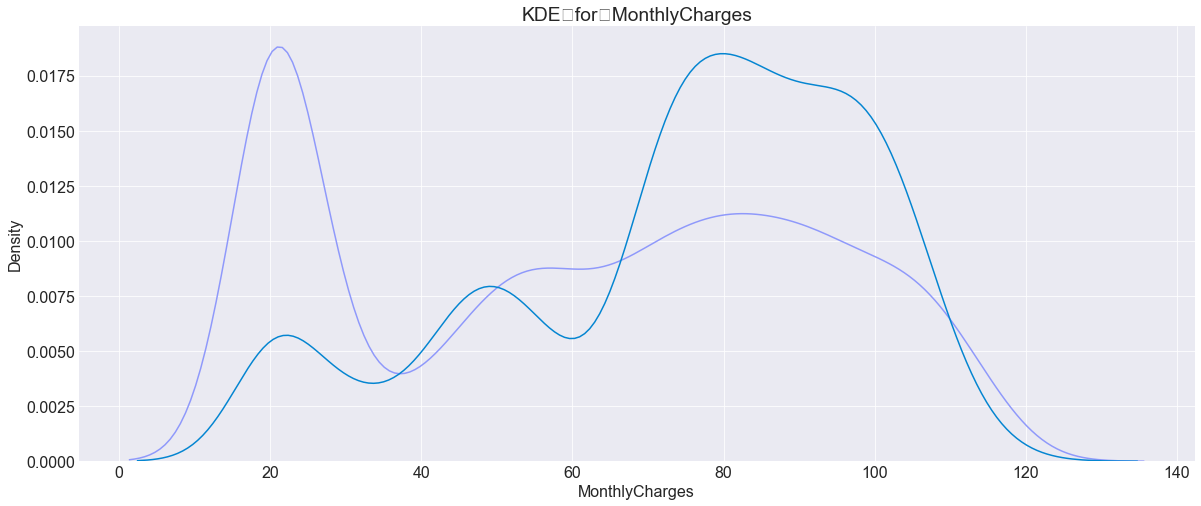

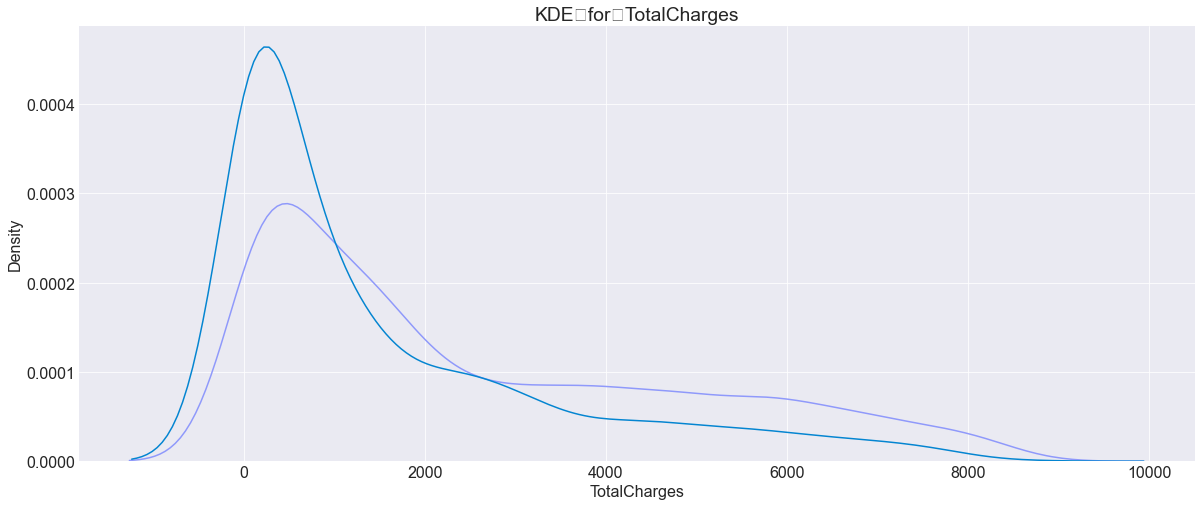

In [31]:
def kdeplot(feature):
				plt.figure(figsize=(20,	8))
				plt.title("KDE	for	{}".format(feature))
				ax0	=	sns.kdeplot(telco_df[telco_df['Churn']	==	'No'][feature].dropna(),	color	=	'#8f99fb',	label=
'Churn:	No')
				ax1	=	sns.kdeplot(telco_df[telco_df['Churn']	==	'Yes'][feature].dropna(),	color	=	'#0485d1',	label=
'Churn:	Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

In [32]:
telco_df.describe().round(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_rate
count,7043.000,7043.000,7043.000,7043.000,7043.000
mean,0.162,32.371,64.762,2279.732,0.265
std,0.369,24.559,30.090,2266.794,0.442
min,0.000,0.000,18.250,0.000,0.000
25%,0.000,9.000,35.500,398.550,0.000
50%,0.000,29.000,70.350,1394.550,0.000
75%,0.000,55.000,89.850,3786.600,1.000
max,1.000,72.000,118.750,8684.800,1.000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 10390.710148925598)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


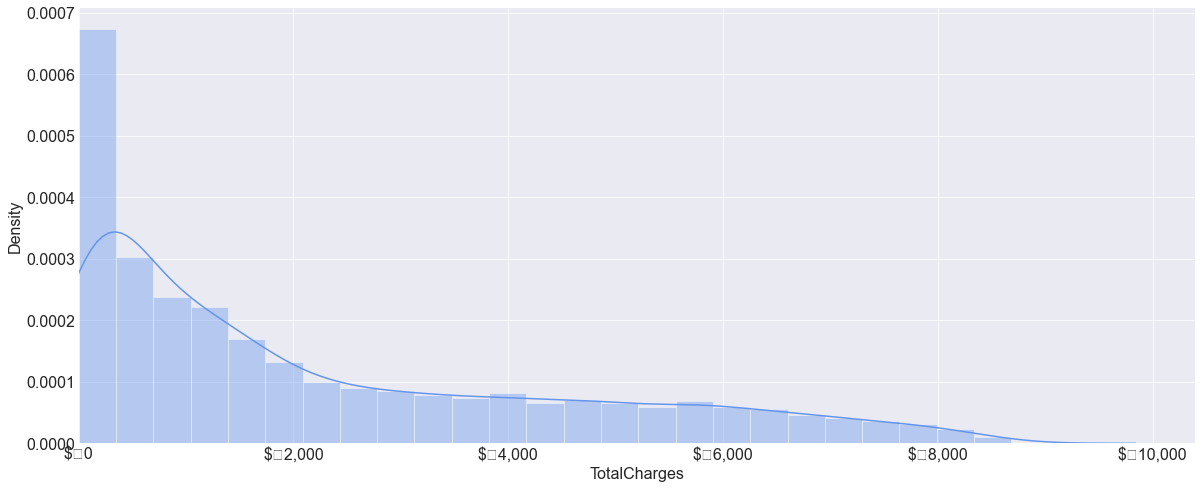

In [33]:
ax	=	sns.distplot(telco_df['TotalCharges'],	color	=	'cornflowerblue')
#	Set	x	tick.
fmt	=	'$	{x:,.0f}'
tick	=	ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
#	Set	the	range	of	x	axis
plt.xlim(0,	None)

In [6]:
#	Trimming	off	the	outliers	of	the	distribution.
starting_percentile	=	telco_df['TotalCharges'].quantile(.01)
ending_percentile	=	telco_df['TotalCharges'].quantile(.99)
print("Starting	percentile:	",	starting_percentile)
print("Ending	percentile:	",	ending_percentile)

Starting	percentile:	 19.75
Ending	percentile:	 8039.256025390625


In [7]:
totalCharges_outliers	=	telco_df.loc[((telco_df['TotalCharges']	<=	starting_percentile)	|
(telco_df['TotalCharges']	>=	ending_percentile))]
totalCharges_outliers['TotalCharges'].describe().to_frame()

,TotalCharges
count,145.000000
mean,4069.230713
std,4153.490723
min,0.000000
25%,19.450001
50%,19.750000
75%,8297.500000
max,8684.799805


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


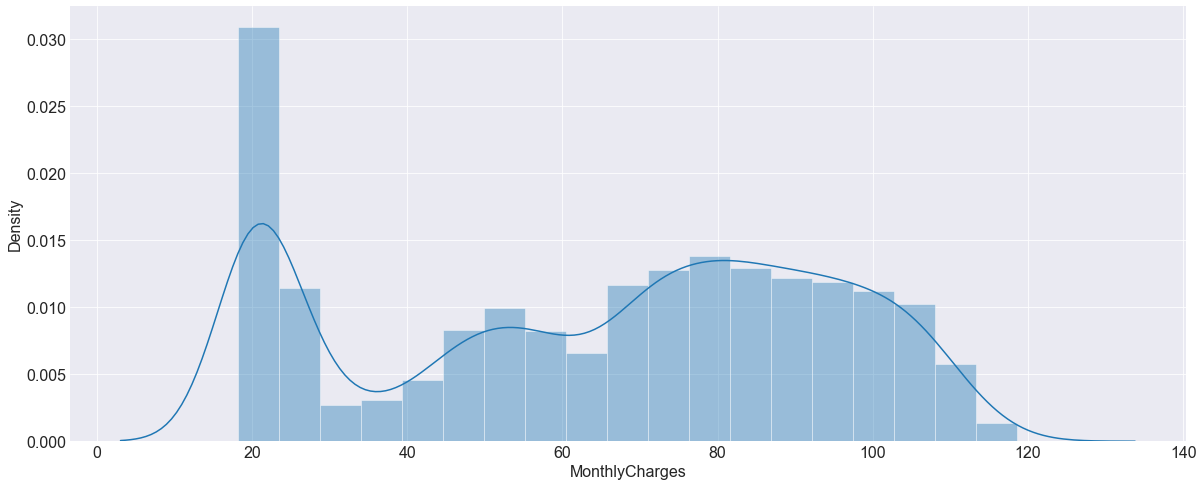

In [36]:
telco_df	=	telco_df.loc[((telco_df['TotalCharges']	> starting_percentile)	&	(telco_df['TotalCharges']	<
ending_percentile))]
ax	=	sns.distplot(telco_df['MonthlyCharges'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


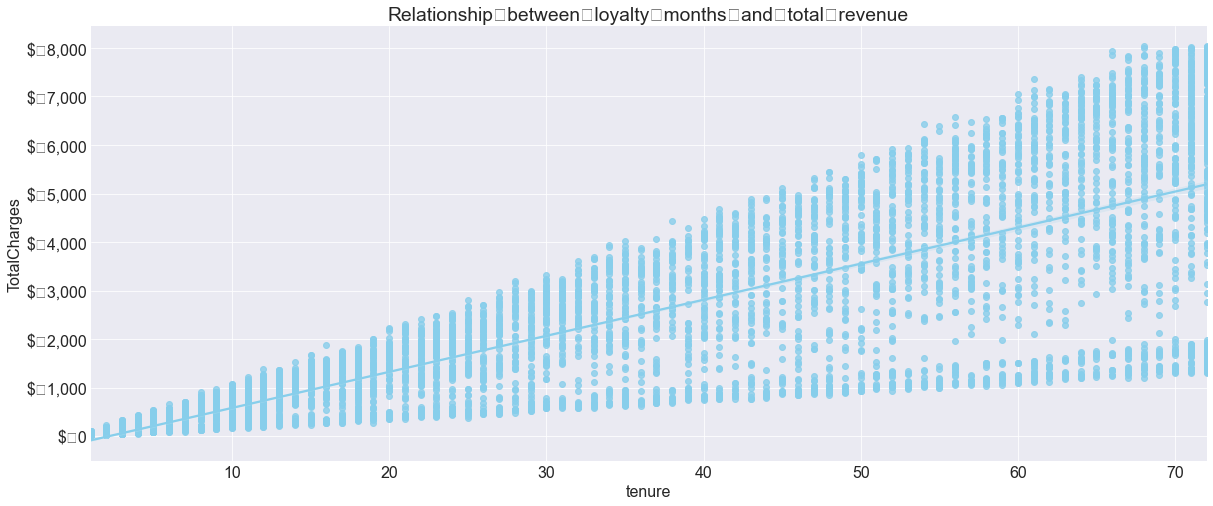

In [37]:
numerics	=	telco_df[['tenure','MonthlyCharges',	'TotalCharges',	'Churn']]
plt.figure(figsize	=	(20,	8))
ax	=	sns.regplot(x	=	'tenure',	y	=	'TotalCharges',	data	=	numerics,	color	=	'skyblue')
plt.title('Relationship	between	loyalty	months	and	total	revenue')
#	Set	y	tick.
fmt	=	'$	{x:,.0f}'
tick	=	ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


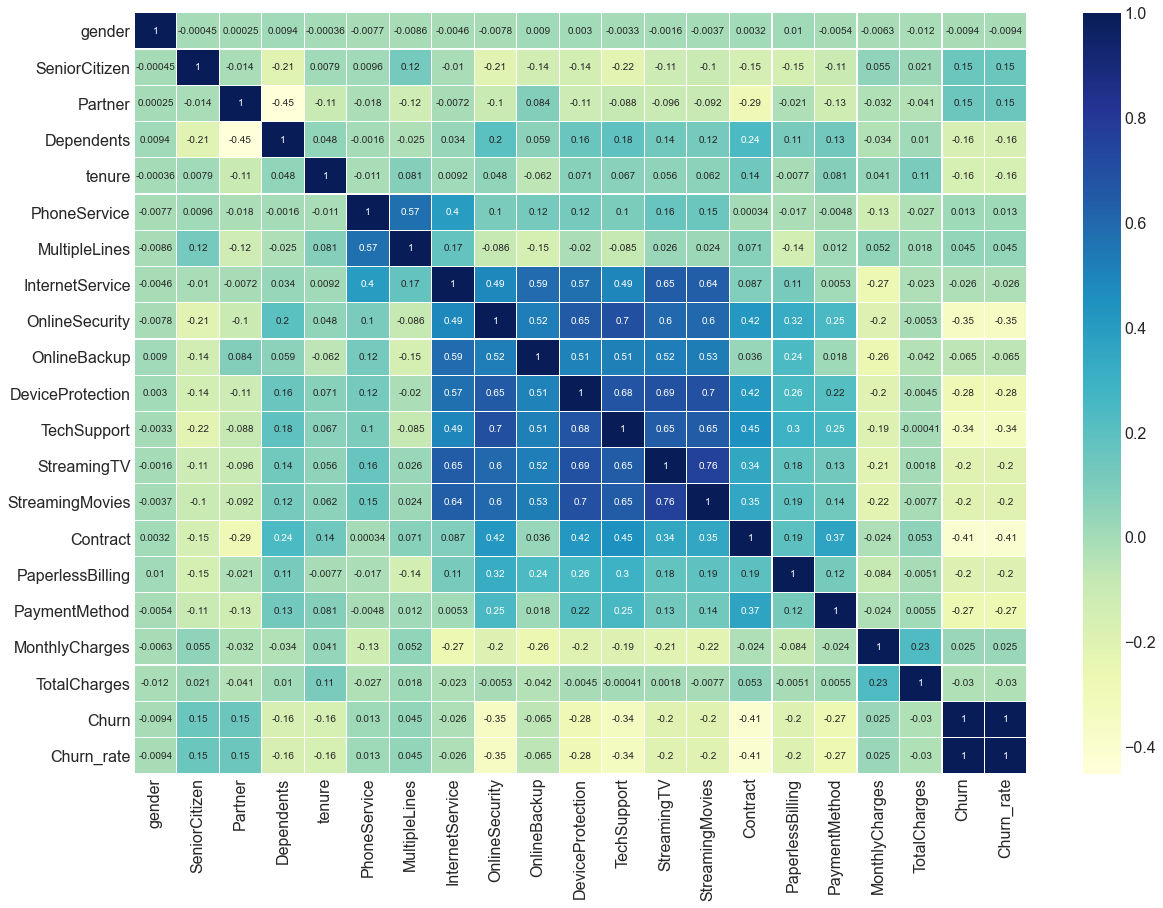

In [38]:
plt.figure(figsize=(20,	14))
telco_df.drop(['customerID'],	axis	=	1,	inplace	=	True)
corr	=	telco_df.apply(lambda x:	pd.factorize(x)[0]).corr('spearman')
ax	=	sns.heatmap(corr,	xticklabels	=	corr.columns,	yticklabels	=	corr.columns,
																	linewidths	=	.2,	cmap	=	"YlGnBu",	annot	=	True,	annot_kws	=	{'size':10})
sns.set(font_scale	=	1.25)

# Data Preprocessing for Models

In [8]:
#	Drop	null	data	of	TotalCharges
telco_df.dropna(axis=0,inplace=True)
#	Check	the	number	of	missing	values.
telco_df.isnull().sum().max()

0

In [9]:
telco_df_dummies	=	pd.get_dummies(telco_df.iloc[:,1:])
telco_df_dummies_clean	=	telco_df_dummies.drop(['Churn_No'],axis=1)
telco_df_dummies_clean.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.850000,1,0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.500000,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,2,53.85,108.150002,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0,1,1


In [10]:
col_name	=	telco_df_dummies_clean.columns.to_list()
col_name.remove('Churn_Yes')
col_name	=	[	x for x in col_name if "No" not in x]
col_name

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'TechSupport_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [11]:
#	standardized	the	different	columns	(covert	to	same	scale)
x	=	telco_df_dummies_clean[col_name]
scaler	=	preprocessing.StandardScaler().fit(x)
x	=	pd.DataFrame(scaler.transform(x),	columns	=	x.columns)

In [12]:
x

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.992611,1.009559,-1.009559,1.034530,-0.654012,-3.054010,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
1,-0.439916,0.066327,-0.259629,-0.172165,-0.990532,0.990532,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,-1.105970,1.944582,-0.562975,-1.205113,-0.529885,-0.525047,-0.711026,1.835513
2,-0.439916,-1.236724,-0.362660,-0.958066,-0.990532,0.990532,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513
3,-0.439916,0.514251,-0.746535,-0.193672,-0.990532,0.990532,-0.966622,-0.654012,-3.054010,-0.854176,...,-0.790132,-0.796070,-1.105970,1.944582,-0.562975,-1.205113,1.887201,-0.525047,-0.711026,-0.544807
4,-0.439916,-1.236724,0.197365,-0.938874,1.009559,-1.009559,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.665992,-0.127605,-0.990532,0.990532,1.034530,1.529024,0.327438,1.170719,...,1.265612,1.256171,-1.105970,1.944582,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513
7039,-0.439916,1.613701,1.277533,2.242606,1.009559,-1.009559,1.034530,1.529024,0.327438,1.170719,...,1.265612,1.256171,-1.105970,1.944582,-0.562975,0.829798,-0.529885,1.904590,-0.711026,-0.544807
7040,-0.439916,-0.870241,-1.168632,-0.852932,1.009559,-1.009559,1.034530,1.529024,-3.054010,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
7041,2.273159,-1.155283,0.320338,-0.870513,-0.990532,0.990532,1.034530,-0.654012,0.327438,1.170719,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513


# Models
## Logistic Regression

In [53]:
#	Apply	Ridge	regression
y=telco_df_dummies_clean['Churn_Yes']
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [56]:
#Initialize Logistic Regressor
logmodel=LogisticRegression(random_state= 10)
#Fit the model
logmodel.fit(X_train, y_train)
#Let's score the model
logmodel.score(X_test, y_test)

0.8048261178140526

In [57]:
#Get predictions for the test set
log_pred =logmodel.predict(X_test)

In [58]:
#	Regression	Model	Evaluation	metrics
print('Accuracy Score:' + str(accuracy_score(y_test,log_pred)))
print('Precision Score:' + str(precision_score(y_test,log_pred)))
print('Recall Score:' + str(recall_score(y_test,log_pred)))
print('F1 Score:' + str(f1_score(y_test,log_pred)))

Accuracy Score:0.8048261178140526
Precision Score:0.6118421052631579
Recall Score:0.5422740524781341
F1 Score:0.5749613601236476


In [19]:
#	Train	and	test	sets:	80%	and	20%
y	=	telco_df_dummies_clean['Churn_Yes']
X_train,	X_test,	y_train,	y_test	=	train_test_split(x,	y,	test_size=0.2,	random_state=10)

In [20]:
#Initialize	Logistic	Regressor
model=LogisticRegression(random_state=10)
#Fit	the	model
model.fit(X_train,y_train)
#Let's	score	the	model
model.score(X_test,	y_test)

0.8048261178140526

In [59]:
correlation_df	=	pd.DataFrame(telco_df_dummies_clean[col_name+['Churn_Yes']].corr()
['Churn_Yes'].abs().sort_values(ascending	=	False)).reset_index()
col	=	['Variables',	'Correlations']
correlation_df.columns	=	col
correlation_df['Variables']	=	correlation_df.where(correlation_df.Correlations > 0.1)
correlation_df.dropna().Variables.to_list()

['Churn_Yes',
 'Contract_Month-to-month',
 'tenure',
 'InternetService_Fiber optic',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'TotalCharges',
 'MonthlyCharges',
 'PaperlessBilling_Yes',
 'Contract_One year',
 'OnlineSecurity_Yes',
 'TechSupport_Yes',
 'Dependents_Yes',
 'SeniorCitizen',
 'Partner_Yes',
 'PaymentMethod_Credit card (automatic)',
 'InternetService_DSL',
 'PaymentMethod_Bank transfer (automatic)']

<Figure size 1656x576 with 0 Axes>

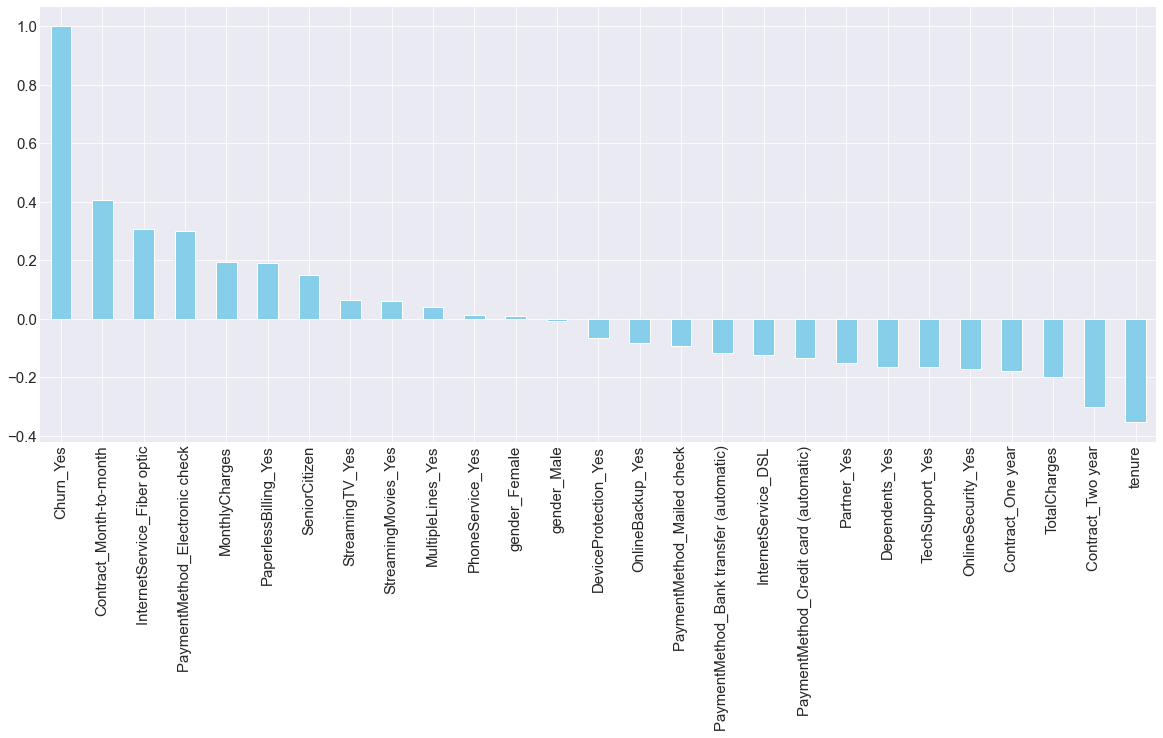

<Figure size 1656x576 with 0 Axes>

In [61]:
fig=telco_df_dummies_clean[col_name+['Churn_Yes']].corr()['Churn_Yes'].sort_values(ascending=False).plot(kind='bar',color = 'skyblue',fontsize = 15)
plt.figure(figsize=(23,	8))

### GridSearch for Best Logistic Regression

In [157]:
# define the grid for Logistic Regression
c_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

grid_params_lr = [{'C' : c_params, 'solver' : ['liblinear', 'saga'], 
                   'penalty': ['l1', 'l2'], 
                   'class_weight' : [None, 'balanced', 
                                         {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}]}]

In [164]:
SEED = 19
# create Logistic Regression classifier object
model_lr = LogisticRegression(random_state=19, fit_intercept=False, max_iter=500, n_jobs=-1)
# create gridsearchCV object for Logistic Regression
gs_lr = instantiate_grid(model_lr, grid_params_lr)

# execute the Logistic Regression gridsearchCV on training data
gs_lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=LogisticRegression(fit_intercept=False, max_iter=500,
                                          n_jobs=-1, random_state=19),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

{'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'penalty': 'l2', 'solver': 'liblinear'}


[Text(0, 0.5, 'Retain'), Text(0, 1.5, 'Chrun')]

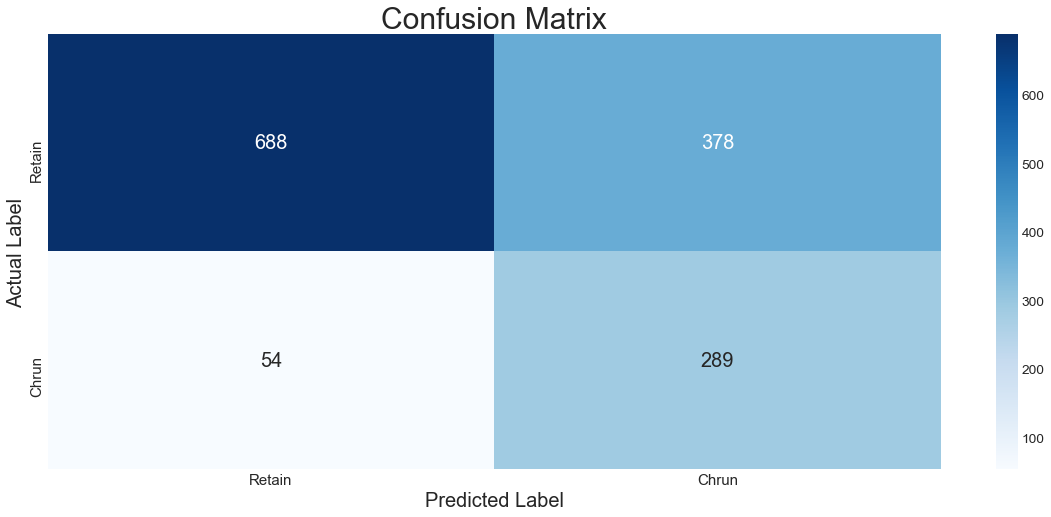

In [171]:
print(gs_lr.best_params_)

# print confusion matrix (train) for best model
best_model_lr = gs_lr.best_estimator_
best_lr_pred = best_model_lr.predict(X_test)

fig=sns.heatmap(confusion_matrix(y_test, best_lr_pred),annot=True,fmt="d",cmap="Blues",annot_kws={"size":20})
fig.set_xlabel('Predicted Label',fontsize=20)
fig.set_ylabel('Actual Label',fontsize=20)
fig.set_title('Confusion Matrix',fontsize=30)
fig.set_xticklabels(['Retain','Chrun'],fontsize=15)
fig.set_yticklabels(['Retain','Chrun'],	fontsize=15)

In [238]:
score_lr = score_pred('lr','test',y_test,best_lr_pred)
#	Regression	Model	Evaluation	metrics
print('Accuracy Score:' + str(accuracy_score(y_test,best_lr_pred)))
print('Precision Score:' + str(precision_score(y_test,best_lr_pred)))
print('Recall Score:' + str(recall_score(y_test,best_lr_pred)))
print('F1 Score:' + str(f1_score(y_test,best_lr_pred)))

Model lr Predictions: AUC 0.74 | Accuracy 0.69 | Recall 0.84 | Precision 0.43 | F1 0.57
Accuracy Score:0.6933995741660752
Precision Score:0.4332833583208396
Recall Score:0.8425655976676385
F1 Score:0.5722772277227723


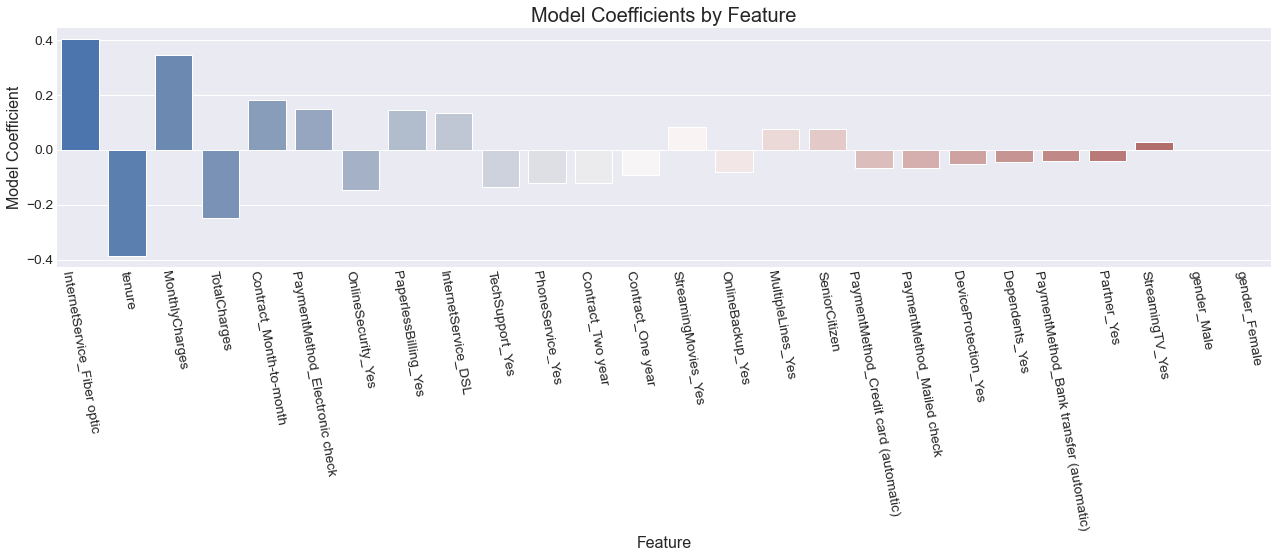

,feature,coef
11,InternetService_Fiber optic,0.404830
1,tenure,-0.386054
2,MonthlyCharges,0.345242
3,TotalCharges,-0.249088
18,Contract_Month-to-month,0.180734
24,PaymentMethod_Electronic check,0.150536
12,OnlineSecurity_Yes,-0.147412
21,PaperlessBilling_Yes,0.147313
10,InternetService_DSL,0.135733
15,TechSupport_Yes,-0.134147


In [245]:
# plot Random Forest feature importance for best estimator
feature_importance(best_model_lr, X_train)

Area under ROC curve is:0.833705741744567


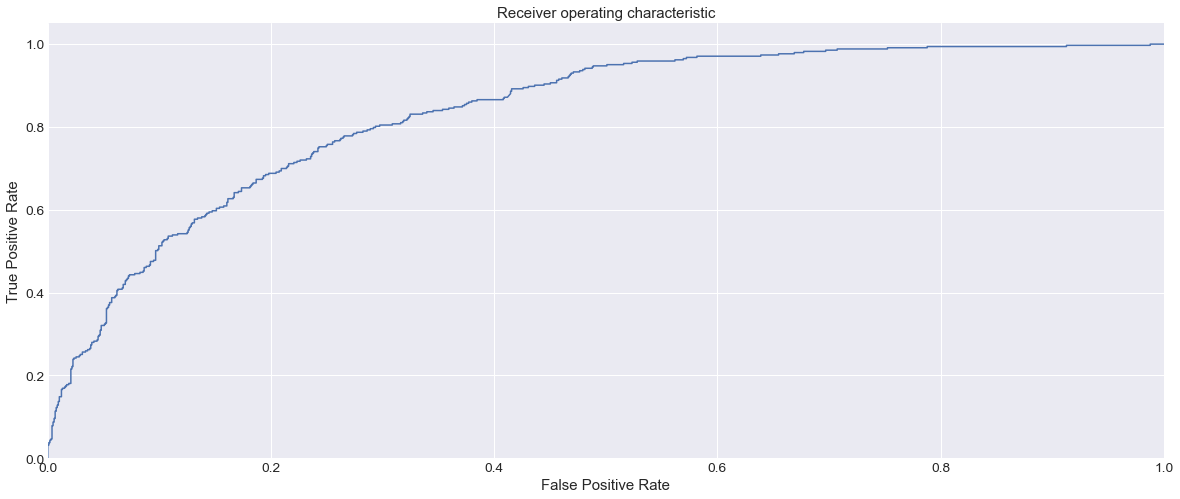

In [181]:
y_pred_prob = best_model_lr.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
                fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:,1:])
                roc_auc[i] = auc(fpr[i], tpr[i])
print("Area under ROC curve is:" + str(roc_auc_score(y_test, y_pred_prob[:,1:])))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


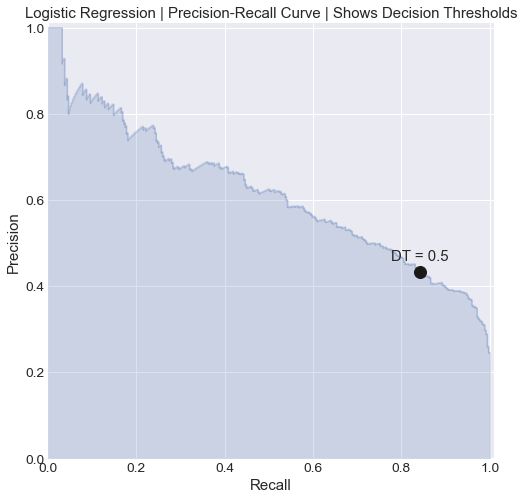

In [186]:
# generate Logistic Regression predict probabilities; store precision-recall curve values
y_hat_prob_test = gs_lr.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_hat_prob_test)

# plot precision-recall curve for baseline decision threshold 0.5
pr_curve(p, r, thresholds, 'Logistic Regression', dt=[0.5])

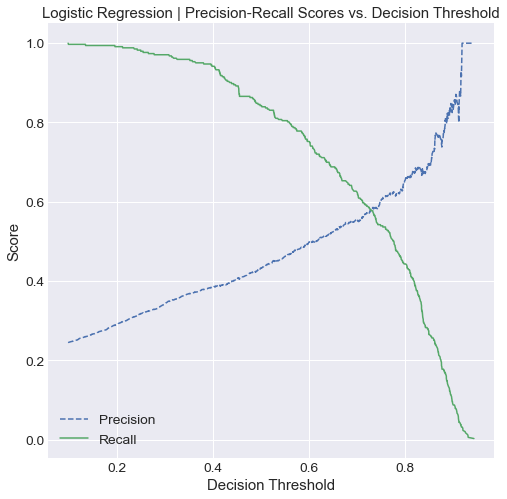

In [189]:
# plot precision and recall against decision threshold options
pr_vs_dt(p, r, thresholds, 'Logistic Regression')

In [193]:
# revised class predictions using decision threshold 0.50
y_hat_high_test = assign_class(y_hat_prob_test, dt=0.69)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_high_test)

               Retain Pred  Churn Pred
Retain Actual          888         178
Churn Actual           125         218
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1066
           1       0.55      0.64      0.59       343

    accuracy                           0.78      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.80      0.78      0.79      1409



Logistic Regression Model AUC 0.744


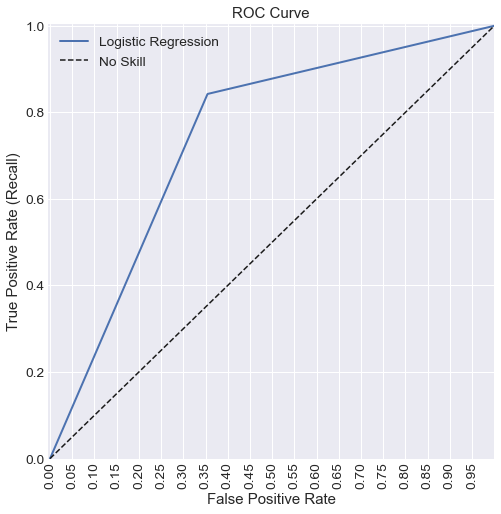

In [195]:
# plot the ROC Area Under Curve for Logistic Regression
fpr2, tpr2, auc_thresholds2 = roc_curve(y_test, best_lr_pred)
print(f'Logistic Regression Model AUC {round(auc(fpr2, tpr2), 3)}') # AUC of ROC
plot_roc_curve(fpr2, tpr2, 'Logistic Regression')

In [196]:
# Fit the training data
sm_lr = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(sm_lr.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5610
Method:                           MLE   Df Model:                           23
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                     inf
Time:                        18:42:24   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -1.6767    

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


## Decision Tree

In [45]:
#	Standardized	the	different	columns	(covert to same scale)
X	=	telco_df_dummies_clean[col_name]
scaler	=	preprocessing.StandardScaler().fit(X)
#	Set	X	and	y.
X	=	pd.DataFrame(scaler.transform(X), columns	= X.columns)
y	=	telco_df_dummies_clean['Churn_Yes']
#	Train	and	test	sets:	80%	and	20%
X_train,	X_test,	y_train,	y_test	=	train_test_split(X,	y,	test_size	=	0.2,	random_state	=	10)


In [46]:
dtree_model	=	DecisionTreeClassifier(max_depth=200,	criterion='entropy',	min_samples_leaf	=	4,	random_state
=	10)
dtree_model.fit(X_train,	y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=200, min_samples_leaf=4,
                       random_state=10)

Decision	Tree	Training	Data	Accuracy:	0.903
Decision	Tree	Testing	Data	Accuracy:	0.75
Decision	Tree	F1	Score	:	0.4828614008941878


Mean	Decision	Tree	(entropy)	CrossVal	Train	Set	Accuracy	Mean:	0.74	and	Standard	Deviation:	0.02	



Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

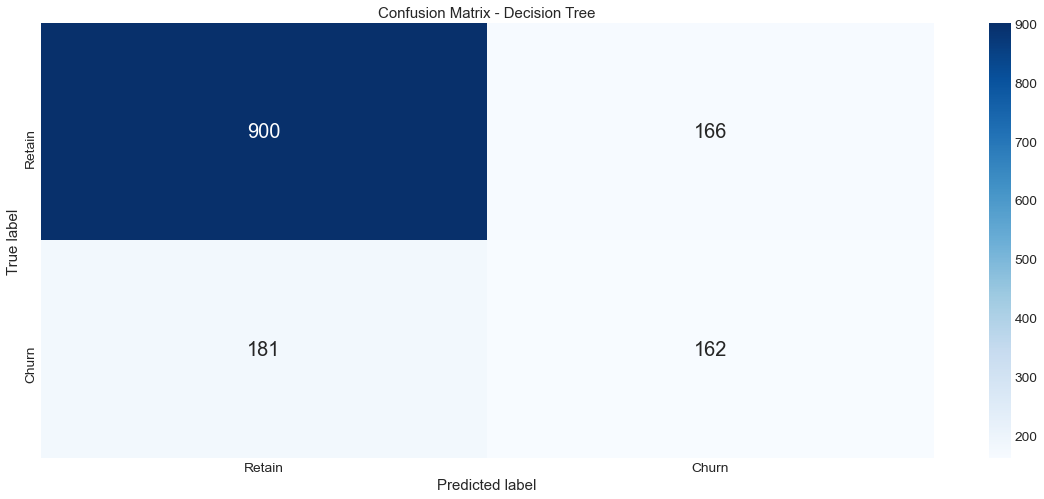

In [155]:
dtree_cm=confusion_matrix(y_test,dtree_pred)
print()

ConfMatrix=confusion_matrix(y_test,dtree_pred)
sns.heatmap(ConfMatrix,annot=True,annot_kws={"size":20},cmap="Blues",fmt="d",xticklabels=['Retain','Churn'],yticklabels=['Retain','Churn'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree")

In [52]:
#	Regression	Model	Evaluation	metrics
print('Accuracy Score:' + str(accuracy_score(y_test,dtree_pred)))
print('Precision Score:' + str(precision_score(y_test,dtree_pred)))
print('Recall Score:' + str(recall_score(y_test,dtree_pred)))
print('F1 Score:' + str(f1_score(y_test,dtree_pred)))

Accuracy Score:0.7537260468417317
Precision Score:0.49390243902439024
Recall Score:0.47230320699708456
F1 Score:0.4828614008941878


In [50]:
#	Number	of	errors
error	=	0
for i,	v in enumerate(dtree_model.predict(X_test)):
		if v !=	y_test.values[i]:
				error	+=	1
print(error)

347


In [51]:
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1066
           1       0.49      0.47      0.48       343

    accuracy                           0.75      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.75      0.75      0.75      1409



In [86]:
param_grid	=	{	'criterion':['gini','entropy'],'max_depth':	np.arange(4,10),'min_samples_leaf':	[5,	10,	20,	30,	40],	'max_leaf_nodes':	[50,	100,	200,	300,	400]}
grid_dtree_acc	=	GridSearchCV(dtree_model,	param_grid,	cv	=	3)
grid_dtree_acc.fit(X_train,	y_train)
#Predict	values	based	on	new	parameters
grid_tree_pred_acc	=	grid_dtree_acc.predict(X_test)
grid_dtree_acc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 40}

In [90]:
#	Train	the	decision	tree	model
dtree_model2=	DecisionTreeClassifier(criterion=	'gini',max_depth=4,	max_leaf_nodes=	50,	min_samples_leaf =5,random_state=10)
dtree_model2.fit(X_train,	y_train)

#	Show	the	score	of	training	data	set
print('Decision Tree Training Data Accuracy: {:.3f}'.format(accuracy_score(y_train,dtree_model2.predict(X_train))))

#	Show	the	score	of	testing	data	set

dtree_pred2	=	dtree_model2.predict(X_test)
print('Decision Tree Testing Data Accuracy: {:.2f}'.format(accuracy_score(y_test,	dtree_pred)))

dtree_cv_scores2	=	cross_val_score(dtree_model2,	X_train,	y_train,	cv=5)
print('Mean	Decision Tree (entropy) CrossVal Train Set Accuracy	Mean: %.2f and Standard Deviation: %.2f \n'% (dtree_cv_scores2.mean(),	dtree_cv_scores2.std()))

Decision Tree Training Data Accuracy: 0.793
Decision Tree Testing Data Accuracy: 0.75
Mean	Decision Tree (entropy) CrossVal Train Set Accuracy	Mean: 0.78 and Standard Deviation: 0.00 




Model dt Predictions: AUC 0.69 | Accuracy 0.8 | Recall 0.49 | Precision 0.6 | F1 0.54


Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

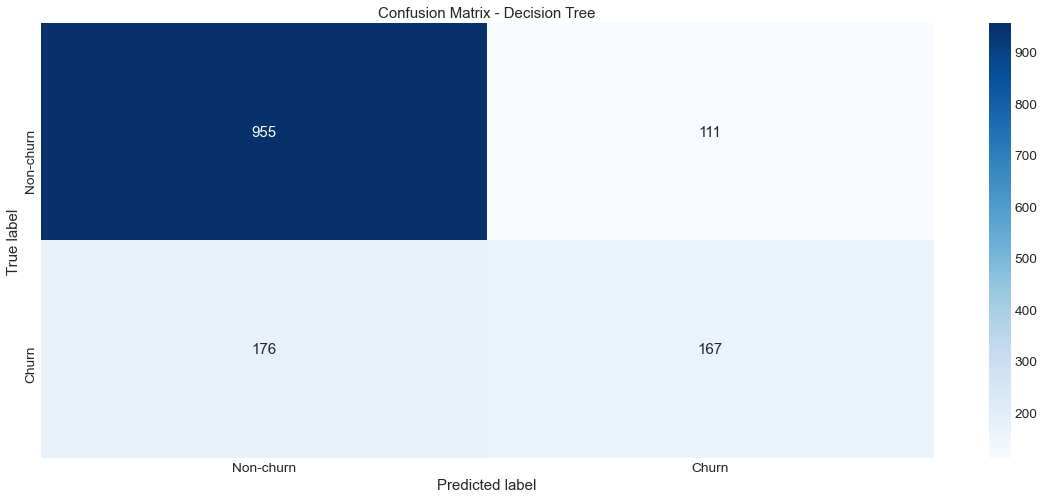

In [240]:
dtree_cm2	=	confusion_matrix(y_test,	dtree_pred2)
print()
score_dt = score_pred('dt','test',y_test, dtree_pred2)
ConfMatrix2	=	confusion_matrix(y_test,	dtree_pred2)
sns.heatmap(ConfMatrix2,annot=True,	cmap="Blues",	fmt="d",xticklabels	=	['Non-churn',	'Churn'],yticklabels	=	['Non-churn',	'Churn'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree")

In [92]:
#	Number	of	errors
error	=	0
for i,	v in enumerate(dtree_model2.predict(X_test)):
		if v !=	y_test.values[i]:
				error	+=	1
print(error)

287


In [93]:
print(classification_report(y_test,	dtree_pred2))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1066
           1       0.60      0.49      0.54       343

    accuracy                           0.80      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.79      0.80      0.79      1409



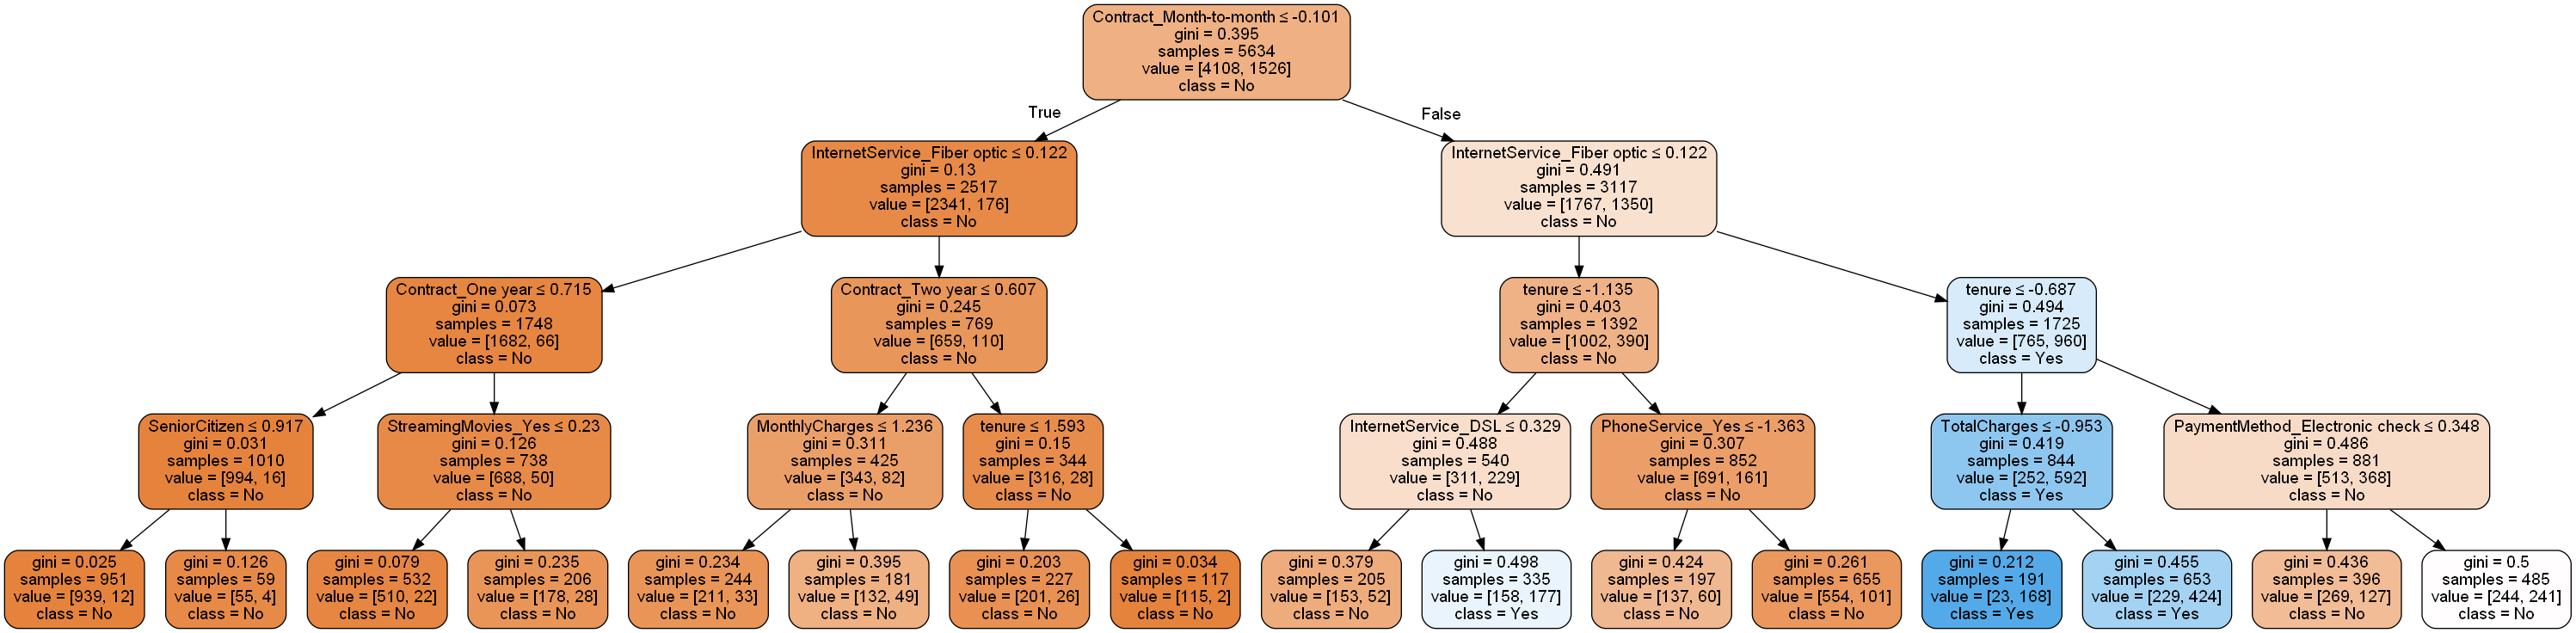

In [98]:
#	Set	the	figure	size.
rcParams['figure.figsize']	=	(20,	8)
dot_data	=	StringIO()
export_graphviz(dtree_model2,	out_file	=	dot_data,	feature_names=list(X),
																class_names=list(telco_df.iloc[1:,-1].unique()),
																filled=True,	rounded=True,	special_characters=True)
graph	=	pydotplus.graph_from_dot_data(dot_data.getvalue())		
Image(graph.create_png())

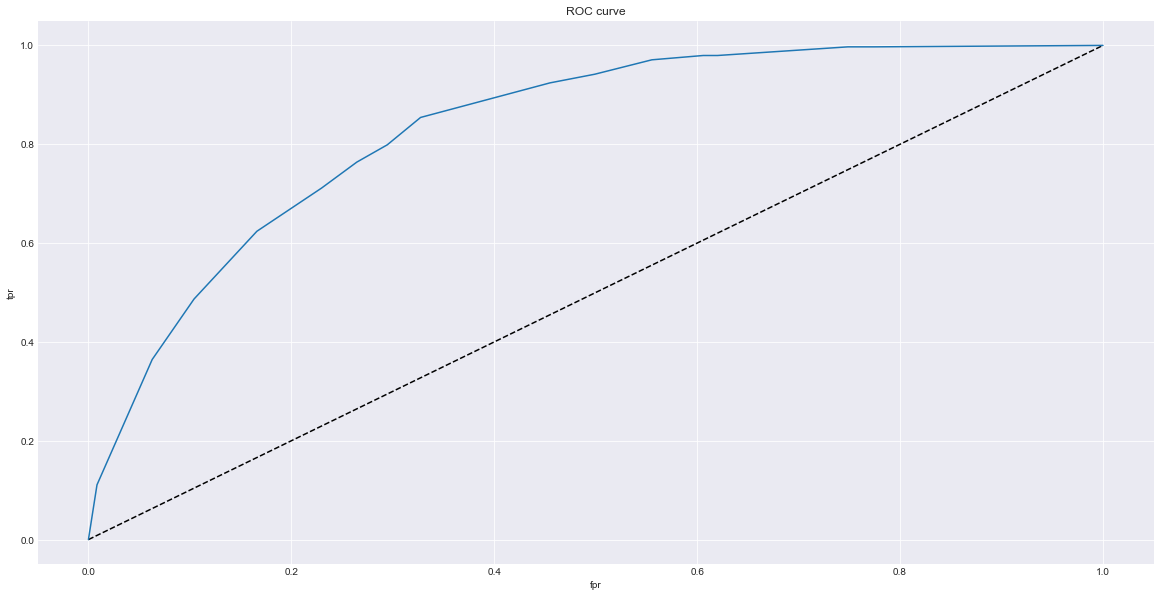

In [100]:
dtree_auc	=	roc_auc_score(y_test,	dtree_model2.predict_proba(X_test)[:,1]).round(2)
dtree_fpr,	dtree_tpr,	dtree_thresholds	=	roc_curve(y_test,	dtree_model2.predict_proba(X_test)[:,	1])
plt.figure(figsize=(20,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(dtree_fpr,	dtree_tpr,	label='Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [101]:
roc_auc_score(y_test,	dtree_model2.predict_proba(X_test)[:,1])

0.8337440309814625

## KNN

In [103]:
#Setup	arrays	to	store	training	and	test	accuracies
neighbors	=	np.arange(1,50)
train_accuracy	=np.empty(len(neighbors))
test_accuracy	=	np.empty(len(neighbors))
for i,k in enumerate(neighbors):
				#	Setup	a	knn	classifier	with	k	neighbors
				knn	=	KNeighborsClassifier(n_neighbors=k)
				
				#	Fit	the	model
				knn.fit(X_train,	y_train)
				
				#	Compute	accuracy	on	the	training	set
				train_accuracy[i]	=	knn.score(X_train,	y_train)
				
				#	Compute	accuracy	on	the	test	set
				test_accuracy[i]	=	knn.score(X_test,	y_test)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


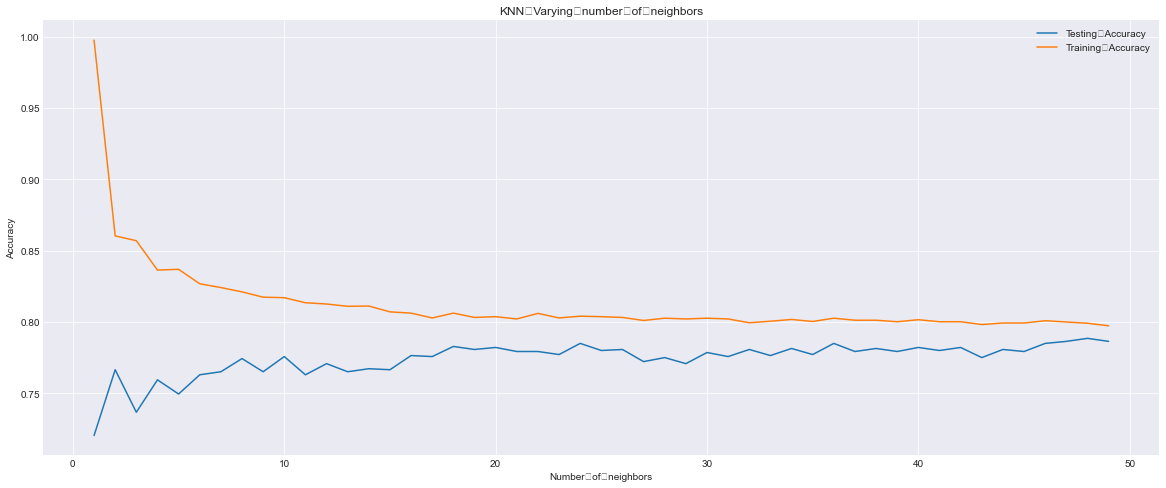

In [104]:
#Generate plot
plt.title('KNN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [105]:
#Based on the above
knn2 = KNeighborsClassifier(n_neighbors=38)

In [106]:
knn2.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=38)

In [108]:
print('knn training score:',	knn2.score(X_train,y_train))
print('knn testing score:',	knn2.score(X_test,y_test))

knn_pred = knn2.predict(X_test)
print('knn F1 Score:' + str(recall_score(y_test,knn_pred)))

knn_cv_scores	=	cross_val_score(knn2,	X_train,	y_train,	cv=5)
print('knn CrossVal Train Set Accuracy Mean:%.2f and Standard Deviation: %.2f \n' %	(knn_cv_scores.mean(),knn_cv_scores.std()))

knn training score: 0.8012069577564785
knn testing score: 0.7814052519517388
knn F1 Score:0.5160349854227405
knn CrossVal Train Set Accuracy Mean:0.79 and Standard Deviation: 0.02 



Text(0.5, 1.0, 'Confusion Matrix - KNN')

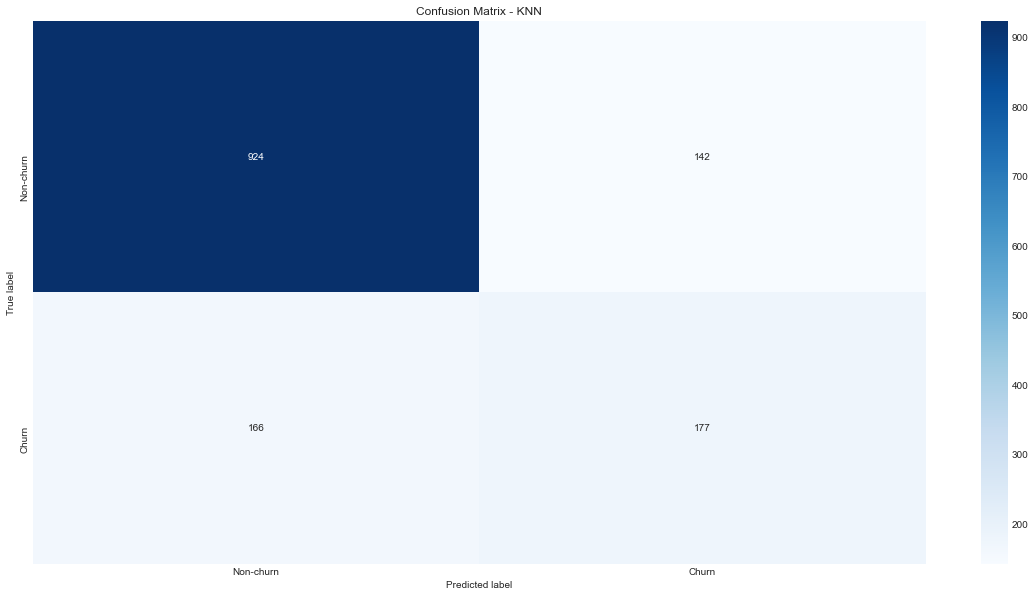

In [109]:
knn_pred	=	knn2.predict(X_test)
ConfMatrix_knn	=	confusion_matrix(y_test,knn_pred)
print()
plt.figure(figsize=(20,10))
sns.heatmap(ConfMatrix_knn,annot=True,	cmap="Blues",	fmt="d",
												xticklabels	=	['Non-churn',	'Churn'],
												yticklabels	=	['Non-churn',	'Churn'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - KNN")

In [110]:
#	Number	of	errors
error	=	0
for i,	v in enumerate(knn2.predict(X_test)):
		if v !=	y_test.values[i]:
				error	+=	1
print(error)

308


In [111]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1066
           1       0.55      0.52      0.53       343

    accuracy                           0.78      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.78      0.78      0.78      1409



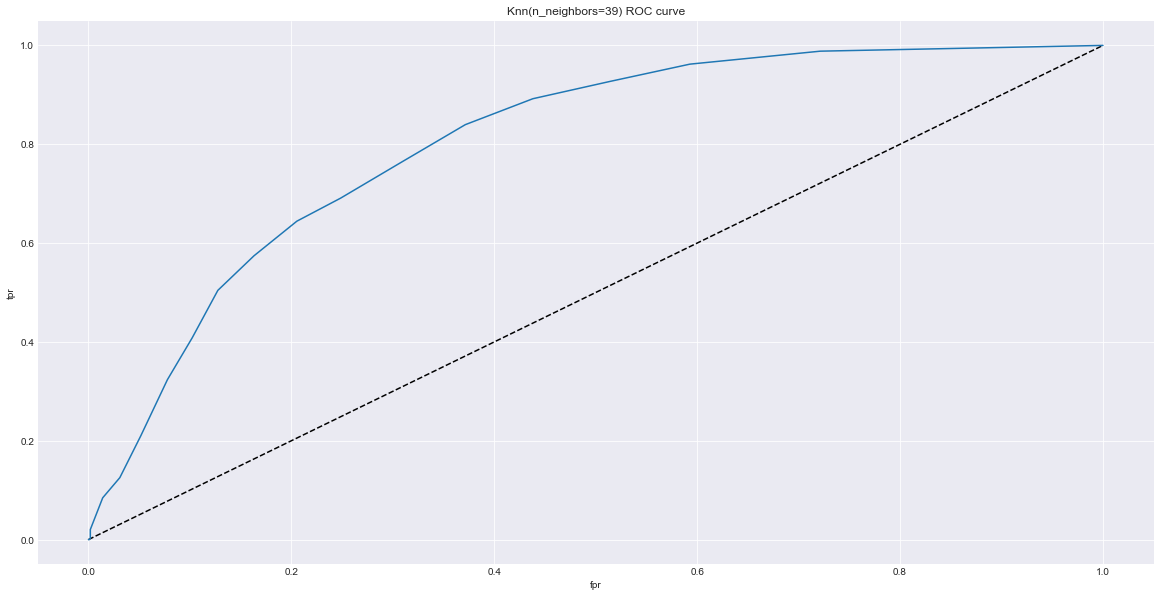

In [112]:
knn2	=	KNeighborsClassifier(n_neighbors=18)
knn2.fit(X_train,y_train)
knn_auc	=	roc_auc_score(y_test,	knn2.predict_proba(X_test)[:,1]).round(2)
knn_fpr,	knn_tpr,	knn_thresholds	=	roc_curve(y_test,	knn2.predict_proba(X_test)[:,	1])
plt.figure(figsize=(20,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(knn_fpr,knn_tpr,	label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=39) ROC curve')
plt.show()

In [113]:
roc_auc_score(y_test,knn2.predict_proba(X_test)[:,1])

0.8047262593056521

## Random Forest

In [114]:
#	Standardized	the	different	columns	(covert	to	same	scale)
X	=	telco_df_dummies_clean[col_name]
scaler	=	preprocessing.StandardScaler().fit(X)
#	Set	X	and	y.
X	=	pd.DataFrame(scaler.transform(X),	columns	=	X.columns)
y	=	telco_df_dummies_clean['Churn_Yes']
#	Train	and	test	sets:	80%	and	20%
X_train,	X_test,	y_train,	y_test	=	train_test_split(X,	y,	test_size	=	0.2,	random_state	=	10)
print	(X_train.shape,	y_train.shape)
print	(X_test.shape,	y_test.shape)
X

(5634, 26) (5634,)
(1409, 26) (1409,)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.992611,1.009559,-1.009559,1.034530,-0.654012,-3.054010,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
1,-0.439916,0.066327,-0.259629,-0.172165,-0.990532,0.990532,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,-1.105970,1.944582,-0.562975,-1.205113,-0.529885,-0.525047,-0.711026,1.835513
2,-0.439916,-1.236724,-0.362660,-0.958066,-0.990532,0.990532,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513
3,-0.439916,0.514251,-0.746535,-0.193672,-0.990532,0.990532,-0.966622,-0.654012,-3.054010,-0.854176,...,-0.790132,-0.796070,-1.105970,1.944582,-0.562975,-1.205113,1.887201,-0.525047,-0.711026,-0.544807
4,-0.439916,-1.236724,0.197365,-0.938874,1.009559,-1.009559,-0.966622,-0.654012,0.327438,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.665992,-0.127605,-0.990532,0.990532,1.034530,1.529024,0.327438,1.170719,...,1.265612,1.256171,-1.105970,1.944582,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513
7039,-0.439916,1.613701,1.277533,2.242606,1.009559,-1.009559,1.034530,1.529024,0.327438,1.170719,...,1.265612,1.256171,-1.105970,1.944582,-0.562975,0.829798,-0.529885,1.904590,-0.711026,-0.544807
7040,-0.439916,-0.870241,-1.168632,-0.852932,1.009559,-1.009559,1.034530,1.529024,-3.054010,-0.854176,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,1.406418,-0.544807
7041,2.273159,-1.155283,0.320338,-0.870513,-0.990532,0.990532,1.034530,-0.654012,0.327438,1.170719,...,-0.790132,-0.796070,0.904184,-0.514249,-0.562975,0.829798,-0.529885,-0.525047,-0.711026,1.835513


In [197]:
# create Random Forest classifier object
model_rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

In [198]:
# define the grid for Random Forest
grid_params_rf = [{'criterion': ['gini', 'entropy'], # measures split quality
                   'class_weight': ['balanced'], # adjust imbalanced positive class
                   'n_estimators': [50, 100, 200, 500], # number trees to grow            
                   'max_features': ['auto', 6, None], # features considered at splits
                   'max_depth': [4, 6, 8, 10],  # max nodes in each tree
                   'min_samples_leaf': [5, 10, 15], # samples required in each leaf
                   'min_samples_split': [0.1, 0.2, 0.3, 0.4], # percentage required to split node
                    }]

In [200]:
# create gridsearchCV object for Random Forest
gs_rf = instantiate_grid(model_rf, grid_params_rf)
# execute the Random Forest gridsearchCV on training data
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=19),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 6, 8, 10],
                          'max_features': ['auto', 6, None],
                          'min_samples_leaf': [5, 10, 15],
                          'min_samples_split': [0.1, 0.2, 0.3, 0.4],
                          'n_estimators': [50, 100, 200, 500]}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Model rf Predictions: AUC 0.75 | Accuracy 0.74 | Recall 0.77 | Precision 0.48 | F1 0.59


[Text(0, 0.5, 'Retain'), Text(0, 1.5, 'Chrun')]

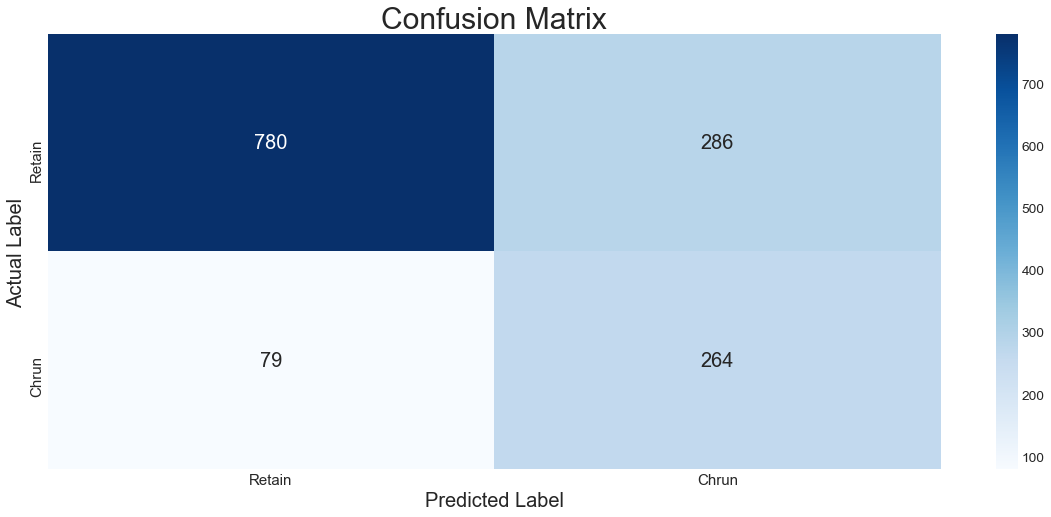

In [239]:
# print confusion matrix (train) for best model
best_rf = gs_rf.best_estimator_
bestrf_pred = best_rf.predict(X_test)

score_rf = score_pred('rf','test',y_test, bestrf_pred)

fig=sns.heatmap(confusion_matrix(y_test, bestrf_pred),annot=True,fmt="d",cmap="Blues",annot_kws={"size":20})
fig.set_xlabel('Predicted Label',fontsize=20)
fig.set_ylabel('Actual Label',fontsize=20)
fig.set_title('Confusion Matrix',fontsize=30)
fig.set_xticklabels(['Retain','Chrun'], fontsize=15)
fig.set_yticklabels(['Retain','Chrun'], fontsize=15)

In [206]:
gs_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=5, min_samples_split=0.1,
                       n_estimators=50, n_jobs=-1, random_state=19)

In [208]:
# Print the model's coefficient value, and make a ranking	dataframe. 
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient'] = pd.Series(best_rf.feature_importances_)
coeff_df = coeff_df.sort_values(by = 'Coefficient', ascending = False).round(4).head(10)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 0.18)

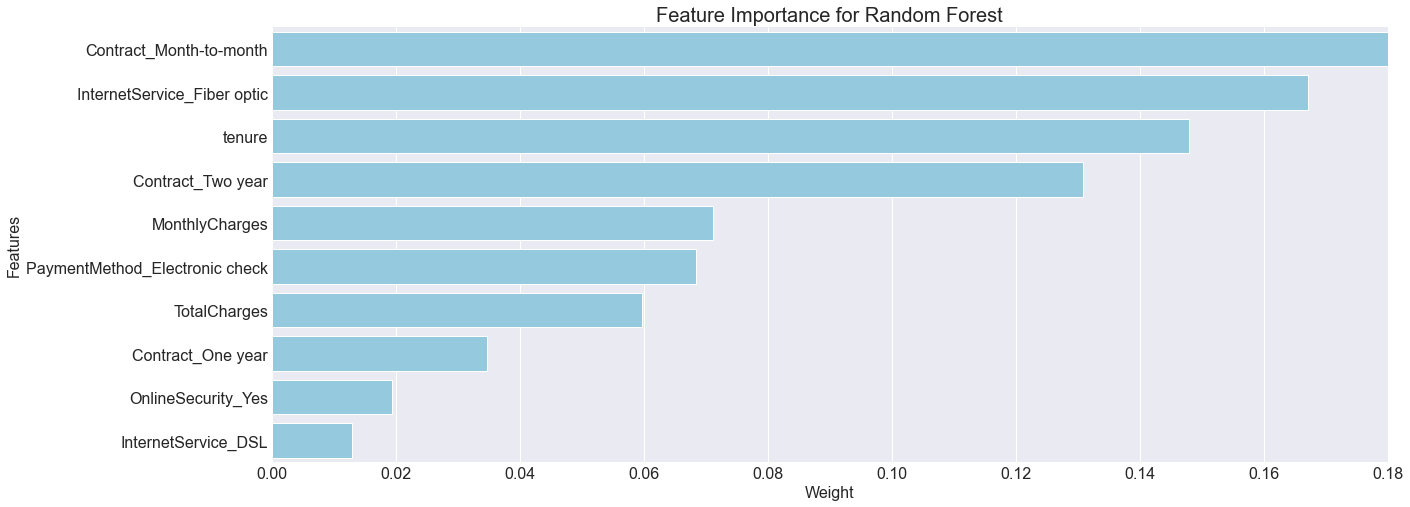

In [209]:
#	Make	barplot
ax	=	sns.barplot('Coefficient',	'Features',	data	=	coeff_df.sort_values(by	=	'Coefficient',	ascending	=False),	capsize	=	0.5,	color	=	"skyblue",	orient	=	'h')
#	Set	x_label,	y_label,	plot	title	name.		
ax.set_xlabel('Weight',	fontsize	=	16)
ax.set_ylabel('Features',	fontsize	=	16)
ax.set_title('Feature Importance for Random Forest',	fontsize	=	20)
#	Set	the	fontsize	for	x	axis	and	y	axis.
ax.tick_params(axis	=	'y',	labelsize	=	16)
ax.tick_params(axis	=	'x',	labelsize	=	16)
#	Set	limit	number	for	x	axis.
plt.xlim(0,	0.18)

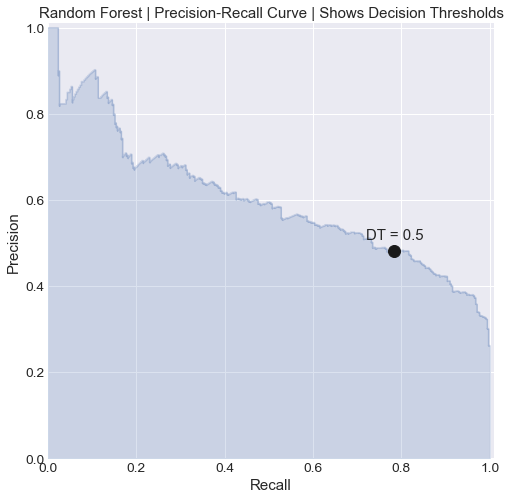

In [212]:
# generate Random Forest predict probabilities; store precision-recall curve values
y_hat_prob_test3 = gs_rf.predict_proba(X_test)[:, 1]
p3, r3, thresholds3 = precision_recall_curve(y_test, y_hat_prob_test3)

# plot precision-recall curve for baseline decision threshold 0.5
pr_curve(p3, r3, thresholds3, 'Random Forest', dt=[0.5])

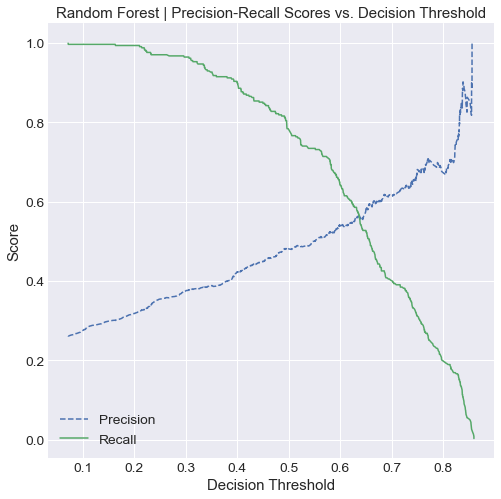

In [213]:
# plot precision and recall against decision threshold options
pr_vs_dt(p3, r3, thresholds3, 'Random Forest')

Random Forest Model AUC 0.751


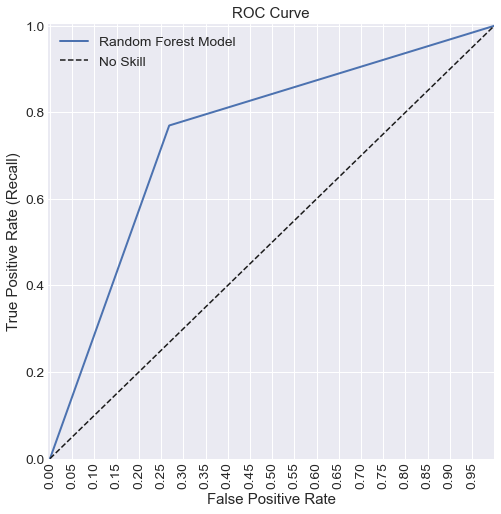

In [214]:
# plot the ROC Area Under Curve for Random Forest
fpr3, tpr3, auc_thresholds3 = roc_curve(y_test, bestrf_pred)
print(f'Random Forest Model AUC {round(auc(fpr3, tpr3), 3)}') # AUC of ROC
plot_roc_curve(fpr3, tpr3, 'Random Forest Model')

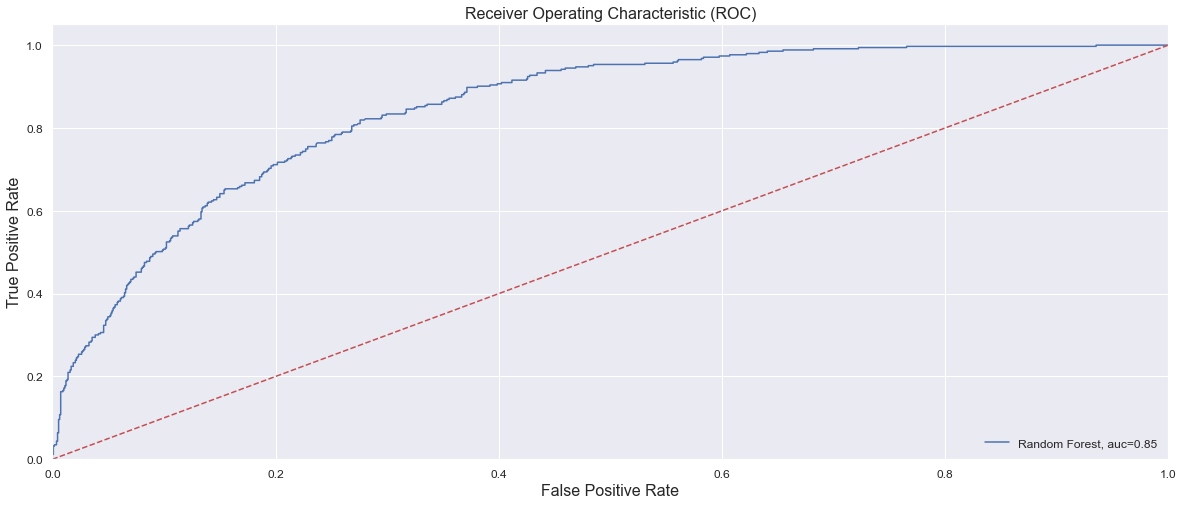

In [134]:
#	Set	the	figure	size.
rcParams['figure.figsize']	=	(20,	8)
#	Compute	ROC	value.
auc	=	roc_auc_score(y_test,	rf_1.predict_proba(X_test)[:,1]).round(2)
rf_fpr,	rf_tpr,	rf_thresholds	=	roc_curve(y_test,	rf_1.predict_proba(X_test)[:,	1])
#	Visualization.
plt.figure()
plt.plot(rf_fpr, rf_tpr, label = 'Random Forest, auc='+str(auc))
plt.plot([0,	1],	[0,	1],	'r--')
plt.xlim([0.0,	1.0])
plt.ylim([0.0,	1.05])
plt.xlabel('False Positive Rate',	fontsize	=	16)
plt.ylabel('True Positive Rate',	fontsize	=	16)
plt.title('Receiver Operating Characteristic (ROC)',	fontsize	=	16)
plt.legend(loc	= 'lower right',	fontsize	=	12)


plt.tick_params(labelsize	=	12)
plt.tick_params(labelsize	=	12)

In [215]:
display_class_report(y_test, bestrf_pred)

               Retain Pred  Churn Pred
Retain Actual          780         286
Churn Actual            79         264
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1066
           1       0.48      0.77      0.59       343

    accuracy                           0.74      1409
   macro avg       0.69      0.75      0.70      1409
weighted avg       0.80      0.74      0.76      1409



## SVM

In [228]:
#Create a svm Classifier
svmclf = svm.SVC(kernel='linear', probability=True)
probas_ = svmclf.fit(X_train, y_train).predict_proba(X_test)

#Predict the response for test dataset
svm_pred = svmclf.predict(X_test)

In [229]:
metrics.accuracy_score(y_test,svm_pred)

0.7984386089425124

In [230]:
#	Regression	Model	Evaluation	metrics
print('Accuracy Score:' + str(accuracy_score(y_test,svm_pred)))
print('Precision Score:' + str(precision_score(y_test,svm_pred)))
print('Recall Score:' + str(recall_score(y_test,svm_pred)))
print('F1 Score:' + str(f1_score(y_test,svm_pred)))

Accuracy Score:0.7984386089425124
Precision Score:0.5986622073578596
Recall Score:0.521865889212828
F1 Score:0.557632398753894


Text(0.5, 1.0, 'Confusion Matrix - SVM')

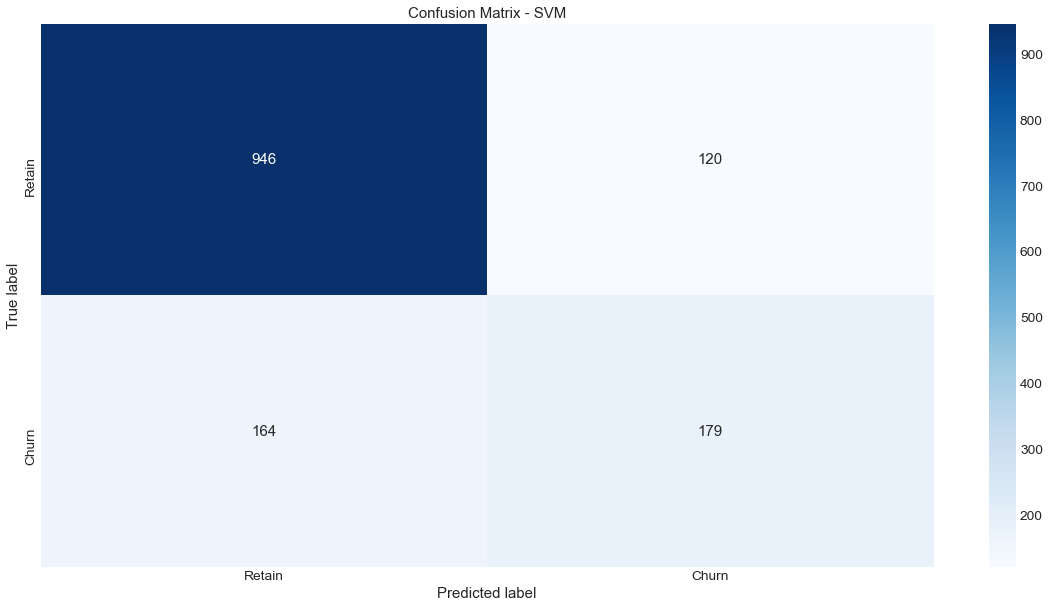

In [236]:
ConfMatrix_svm =confusion_matrix(y_test,svm_pred)
print()
plt.figure(figsize=(20,10))
sns.heatmap(ConfMatrix_svm,annot=True,	cmap="Blues",	fmt="d",xticklabels	=	['Retain',	'Churn'],yticklabels	=	['Retain',	'Churn'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - SVM")

In [233]:
# Compute ROC curve and area the curve
fprsvm, tprsvm, thresholdssvm = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fprsvm, tprsvm)
print ("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.827110


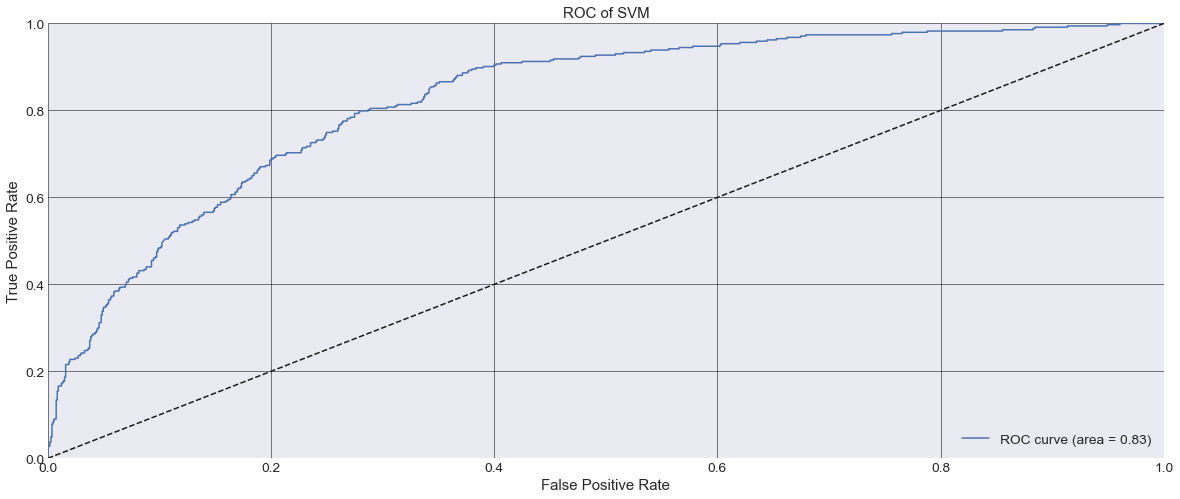

In [246]:
# Plot ROC curve
plt.clf()
plt.plot(fprsvm, tprsvm, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM')
plt.legend(loc="lower right")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



# Traverse Model Result

In [32]:
from sklearn.svm import SVC, LinearSVC  
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
# 使用分类算法，这里选用10种分类算法
Classifiers=[["SVC",LinearSVC()],
             ["SVC2", SVC()],
             ["AdaBoostClassifier", AdaBoostClassifier()],
             ["GradientBoostingClassifier", GradientBoostingClassifier()],
             ["XGBoost", XGBClassifier()],
             ["CatBoost", CatBoostClassifier(logging_level='Silent')]  ]

In [43]:
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier=classifier
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred)
    class_eva=pd.DataFrame([recall,precision,f1score])
    Classify_result.append(class_eva)
    name=pd.Series(name)
    names.append(name)
    y_pred=pd.Series(y_pred)
    prediction.append(y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [44]:
names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=["recall","precision","f1score"]
result

,SVC,SVC2,AdaBoostClassifier,GradientBoostingClassifier,XGBoost,CatBoost
recall,0.521866,0.478134,0.524781,0.504373,0.536443,0.518950
precision,0.608844,0.596364,0.616438,0.609155,0.593548,0.605442
f1score,0.562009,0.530744,0.566929,0.551834,0.563553,0.558870


# Comparison & Conclusion 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


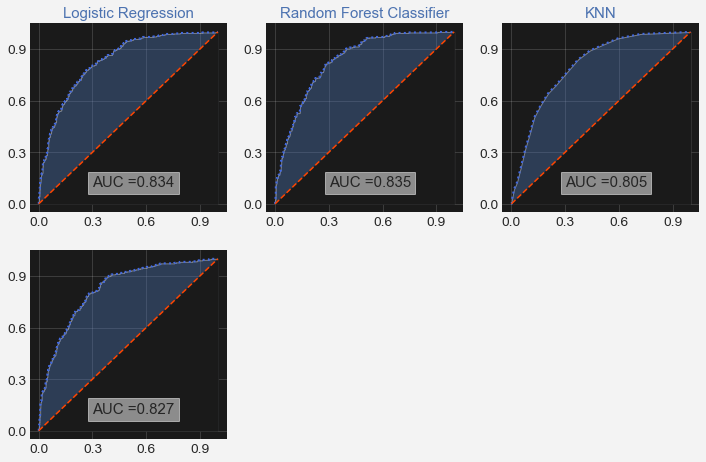

In [243]:
lst	=	[best_model_lr, best_rf, knn2,svmclf]
length	=	len(lst)
mods			=	['Logistic Regression', 'Random Forest Classifier', 'KNN']


fig	=	plt.figure(figsize=(12,	16))
fig.set_facecolor("#F3F3F3")
plt.tight_layout()
for i,j,k in itertools.zip_longest(lst,range(length),mods)	:
				qx	=	plt.subplot(4,3,j+1)
				probabilities	=	i.predict_proba(X_test)
				predictions			=	i.predict(X_test)
				fpr,tpr,thresholds	=	roc_curve(y_test,probabilities[:,1])
				plt.plot(fpr,tpr,linestyle	=	"dotted",
													color	=	"royalblue",linewidth	=	2)
				plt.plot([0,1],[0,1],linestyle	=	"dashed",
													color	=	"orangered",linewidth	=	1.5)
				plt.fill_between(fpr,tpr,alpha	=	.4)
				plt.fill_between([0,1],[0,1],color	=	"k")
				plt.legend(loc	=	"lower right",
															prop	=	{"size"	:	12})
				qx.set_facecolor("k")
				plt.grid(True,alpha	=	.15)
				plt.title(k,color	=	"b")
				plt.text(0.3,0.1,"AUC =" +
str(np.around(roc_auc_score(y_test,probabilities[:,1]),3)),bbox=dict(facecolor='white',	alpha=0.5))
				plt.xticks(np.arange(0,1,.3))
				plt.yticks(np.arange(0,1,.3))

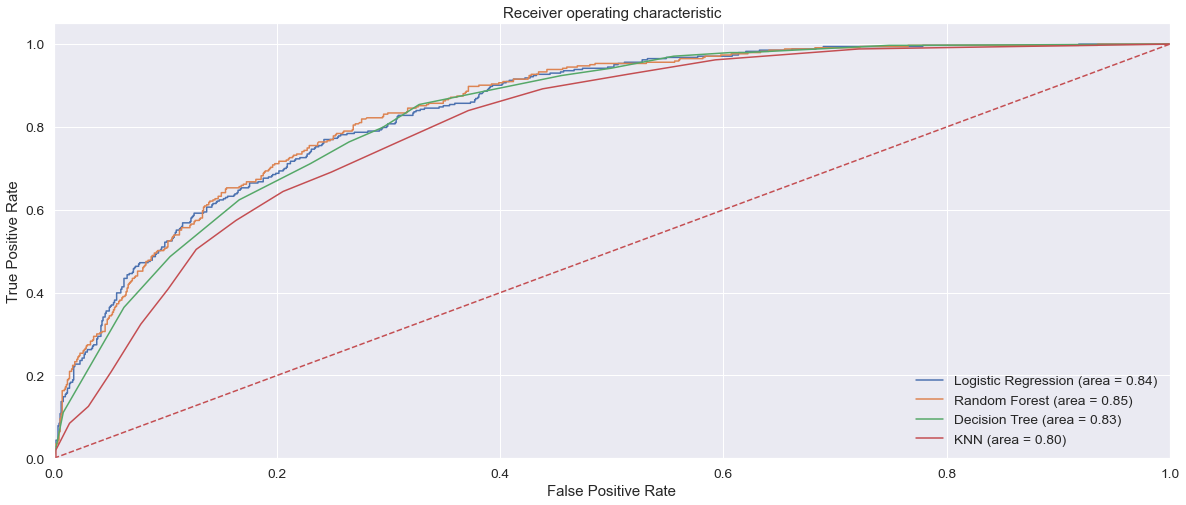

In [149]:
logit_roc_auc	=	roc_auc_score(y_test,	grid_clf_acc.predict_proba(X_test)[:,1])
fpr,	tpr,	thresholds	=	roc_curve(y_test,	grid_clf_acc.predict_proba(X_test)[:,1])
rf_roc_auc	=	roc_auc_score(y_test,	rf_1.predict_proba(X_test)[:,1])
rf_fpr,	rf_tpr,	rf_thresholds	=	roc_curve(y_test,	rf_1.predict_proba(X_test)[:,1])
dtree_roc_auc	=	roc_auc_score(y_test,	dtree_model2.predict_proba(X_test)[:,1])
dtree_fpr,	tdtree_tpr,	thresholds	=	roc_curve(y_test,	dtree_model2.predict_proba(X_test)[:,1])
knn_roc_auc	=	roc_auc_score(y_test,	knn2.predict_proba(X_test)[:,1])
knn_fpr,	knn_tpr,	thresholds	=	roc_curve(y_test,	knn2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,	tpr,	label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr,	rf_tpr,	label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(dtree_fpr,	tdtree_tpr,	label='Decision Tree (area = %0.2f)' % dtree_roc_auc)
plt.plot(knn_fpr,	knn_tpr,	label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0,	1],	[0,	1],'r--')
plt.xlim([0.0,	1.0])
plt.ylim([0.0,	1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [241]:
# export test scores to csv format for Tableau
import csv
toCSV = [score_dt, score_lr, score_rf]
with open('scores_comb.csv', 'w', encoding='utf8', newline='') as output_file:
    fc = csv.DictWriter(output_file, 
                        fieldnames=toCSV[0].keys(),
                       )
    fc.writeheader()
    fc.writerows(toCSV)

# Helper Methods

In [244]:
# plot confusion matrix for classifier object
def display_confusion(model, X, y, labels=None):
    """Plots confusion matrix for a classifier model results

    Parameters:
    - model (classifier): model refit with best estimator during gridsearch
    - X (pd.DataFrame): independent X variables as input to model
    - y (array): y values (can be actual or predicted churn values)
    - labels (str): labels for predicted and actual values

    Returns: none
    """
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, 
                          display_labels=labels)
    plt.grid(False)     
    plt.tight_layout()
    plt.show()
 

def assign_class(y_hat_prob, dt=0.5):
    """
    Calculates churn predictions based on any decision threshold level 
    using a classification model's predicted probability scores.
    
    Parameters:
    - y_hat_prob (array): predicted churn probabilities
    - dt (float): decision threshold value between 0 and 1. Represents 
      predicted probability at which postive class (churn) should be assigned.

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    return [1 if y >= dt else 0 for y in y_hat_prob]


# plot confusion matrix for classifier object
def display_class_report(y_true, y_hat):
    """Prints classification report for a classifier model predictions.

    Parameters:
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y    

    Returns: none
    """
    print(pd.DataFrame(confusion_matrix(y_true, y_hat),
                       columns=['Retain Pred', 'Churn Pred'], 
                       index=['Retain Actual', 'Churn Actual']))
    print(classification_report(y_true, y_hat))
    
    
# key metrics to evaluate model performance
def show_grid_metrics(cv_results, sort_by, top_n=10):
    """Extracts and displays top n sorted rows of evaluation metrics from 
    cross-validation results of a grid search.

    Parameters:
    - cv_results (DataFrame): full cross-validation results from grid search
    - sort_by (str): scoring metric to sort descending high-to-low
    - top_n (int): number of rows to display

    Returns:
    - cv_results_metrics (DataFrame): metrics for each model iteration
    """
    # define evaluation metrics to keep from cv results
    metrics = ['params', 'mean_test_roc_auc', 'mean_test_accuracy', 
               'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 
               'rank_test_roc_auc', 'rank_test_recall']

    cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics.sort_values(by=[sort_by], ascending=False, 
                                   inplace=True)
    display(cv_results_metrics[:top_n])
    return cv_results_metrics

#
def feature_importance(model, X_df):
    """Extracts and plots relative feature importance based on classifier
    model coefficients.

    Parameters:
    - model (classifier): model estimator to use during grid search
    - X_df (pd.DataFrame): dataframe containing all X features/columns

    Returns:
    - coef_table (DataFrame): coefficient table by feature
    """    
    # create feature coefficient dataframe
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    # plot feature coefficient on bar graph
    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table.sort_values(by='coef',key =abs,ascending=False), palette='vlag')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.xticks(rotation=-80)
    plt.tight_layout()
    plt.show()
    
    return coef_table.sort_values(by='coef',key = abs,ascending=False)



def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
    
# function to create standard gridsearchCV object
def instantiate_grid(model, grid_params, refit='roc_auc'):
    """Creates a GridSearchCV object using estimator (model) applying grid 
    parameters and standard scoring metrics. 

    Parameters:
    - model (classifier): model estimator to use during grid search
    - grid_params (dict): lists of parameters for grid search iterations
    - refit (str): indicators scoring metric to refit best estimator

    Returns:
    - gs (object): GridSearchCV instantiation object
    """    
    # set common scoring metrics for use across models
    scoring = {'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=False), 
               'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 
               'f1': make_scorer(f1_score)
              }
    
    # GridSearch uses 5 cross-validation folds within each training iteration
    gs = GridSearchCV(estimator=model, param_grid=grid_params, 
                      scoring=scoring, refit=refit, 
                      cv=StratifiedKFold(n_splits=5, random_state=SEED, 
                                     shuffle=True))
    
    return gs 
    
def pr_curve(p, r, thresholds, model_type, dt=[0.5]):
    """
    Plots the precision-recall curve indicating the current values for a
    classifier decision threshold. Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - dt (float): decision threshold value between 0 and 1. Represents 
      desired probability at which postive class (churn) should be assigned.
    - model_type (str): Text for model type title

    Returns: None
    """
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title(f'{model_type} | Precision-Recall Curve | Shows Decision Thresholds')
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0, 1.01])
    plt.xlim([0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    for t in dt:
        dt_point = np.argmin(np.abs(thresholds - t))
        dt_label = 'DT = '+str(t)
        plt.plot(r[dt_point], p[dt_point], 'o', c='k', markersize=12)
        plt.annotate(dt_label, 
                     (r[dt_point], p[dt_point]),
                     textcoords="offset points", 
                     xytext=(0,12), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        
def pr_vs_dt(p, r, thresholds, model_type):
    """
    Plots precision and recall lines (y) for each value of classifier decision
    threshold (x). Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - model_type (str): Text for model type title

    Returns: None
    """
    plt.figure(figsize=(8, 8))
    plt.title(f'{model_type} | Precision-Recall Scores vs. Decision Threshold')
    plt.plot(thresholds, p[:-1], 'b--', label='Precision')
    plt.plot(thresholds, r[:-1], 'g-', label='Recall')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')
    
# calculates model evaluation metrics by comparing predictions to "true north"
def score_pred(model_type, data_type, y_true, y_hat):
    """Calculates and returns ROC AUC, accuracy, recall, precision, f1 score; 
    prints compact results summary.

    Parameters:
    - model_type (str): identifes type of model (eg. 'rf' = random forest)
    - data_type (str): indicates if y values are from train or test results
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    scores = {}
    scores['model'] = model_type
    scores['data'] = data_type
    scores['auc'] = roc_auc_score(y_true, y_hat)
    scores['acc'] = accuracy_score(y_true, y_hat)
    scores['rec'] = recall_score(y_true, y_hat)
    scores['prec'] = precision_score(y_true, y_hat)
    scores['f1'] = f1_score(y_true, y_hat)   
    print(f'Model {scores["model"]} Predictions: AUC {round(scores["auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Recall {round(scores["rec"], 2)} | '
          f'Precision {round(scores["prec"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )

    return scores